# Baseline RGB - ResNet18
## Beyond Visible Spectrum: AI for Agriculture 2026

**Pipeline:**
1. EDA & Data Loading
2. Dataset & DataLoader
3. Model: ResNet18 pretrained
4. Training với WandB logging
5. Evaluation & Confusion Matrix
6. Inference & Submission

## 1. Imports & Config

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import wandb

# Config
CONFIG = {
    "seed": 42,
    "img_size": 64,
    "batch_size": 32,
    "epochs": 10,
    "lr": 1e-4,
    "val_split": 0.2,
    "num_classes": 3,
    "model_name": "resnet18",
}

# Paths - LOCAL
TRAIN_RGB_DIR = r"G:\My Drive\NCKH\git\dataset\train\RGB"
TEST_RGB_DIR = r"G:\My Drive\NCKH\git\dataset\val\RGB"
CHECKPOINT_DIR = r"G:\My Drive\NCKH\git\checkpoints"

# # Paths - KAGGLE
# TRAIN_RGB_DIR = "/kaggle/input/beyond-visible-spectrum/train/RGB"
# TEST_RGB_DIR = "/kaggle/input/beyond-visible-spectrum/test/RGB"
# CHECKPOINT_DIR = "/kaggle/working"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Set seed
np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])

Device: cuda


## 2. EDA - Exploratory Data Analysis

Total images: 600
Classes: {'Health': 200, 'Other': 200, 'Rust': 200}


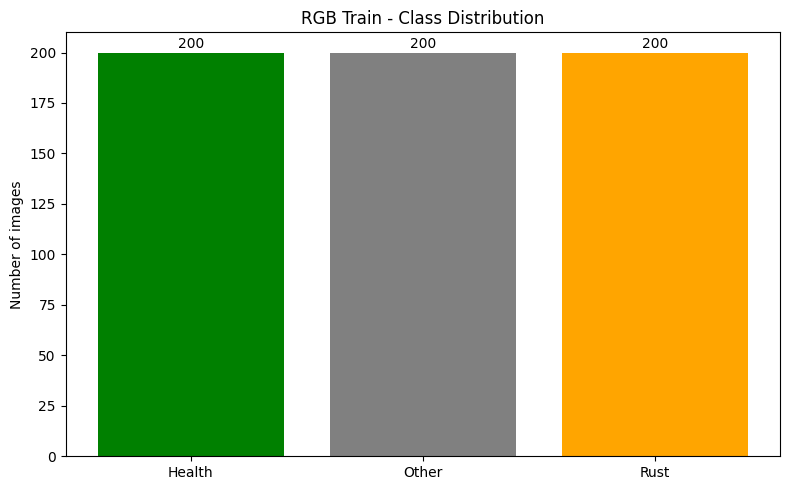

In [23]:
def label_from_filename(fname: str) -> str:
    """Extract label from filename: 'Rust_hyper_184.png' -> 'Rust'"""
    return os.path.basename(fname).split("_")[0]

# Count images per class
files = [f for f in os.listdir(TRAIN_RGB_DIR) if f.lower().endswith(".png")]
class_counts = Counter(label_from_filename(f) for f in files)

print(f"Total images: {len(files)}")
print(f"Classes: {dict(class_counts)}")

# Plot distribution
plt.figure(figsize=(8, 5))
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]
plt.bar(classes, counts, color=['green', 'gray', 'orange'])
plt.ylabel('Number of images')
plt.title('RGB Train - Class Distribution')
for i, v in enumerate(counts):
    plt.text(i, v + 2, str(v), ha='center')
plt.tight_layout()
plt.show()

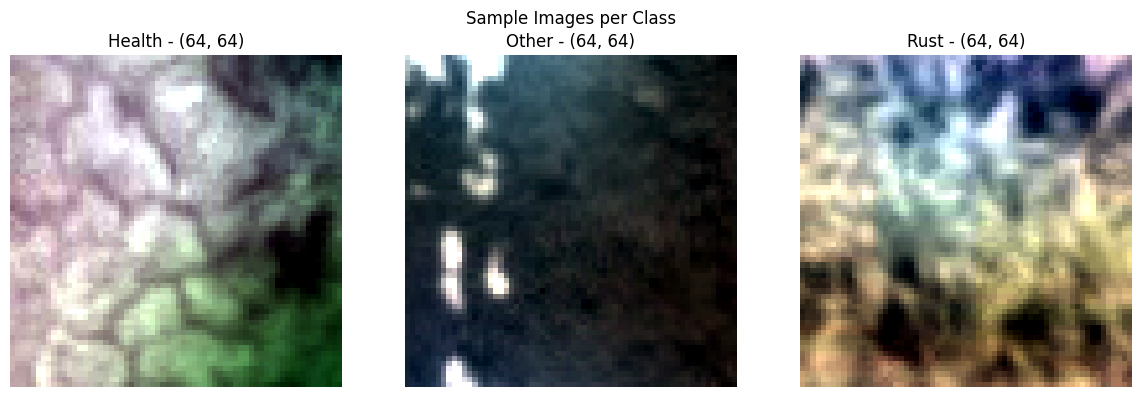

In [24]:
# Show sample images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, cls in enumerate(classes):
    sample_file = [f for f in files if label_from_filename(f) == cls][0]
    img = Image.open(os.path.join(TRAIN_RGB_DIR, sample_file))
    axes[i].imshow(img)
    axes[i].set_title(f"{cls} - {img.size}")
    axes[i].axis('off')

plt.suptitle('Sample Images per Class')
plt.tight_layout()
plt.show()

## 3. Dataset & DataLoader

In [25]:
class RGBDataset(Dataset):
    """RGB Image Dataset - loads PNG images with labels from filename"""
    
    def __init__(self, img_dir, transform=None, file_list=None):
        self.img_dir = img_dir
        self.transform = transform
        
        if file_list is not None:
            self.files = file_list
        else:
            self.files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(".png")])
        
        # Create label mapping
        labels = sorted({label_from_filename(f) for f in self.files})
        self.class_to_idx = {c: i for i, c in enumerate(labels)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}
        self.y = [self.class_to_idx[label_from_filename(f)] for f in self.files]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        label = self.y[idx]
        
        img_path = os.path.join(self.img_dir, fname)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        return img, label


class RGBTestDataset(Dataset):
    """RGB Test Dataset - returns image and filename (no label)"""
    
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(".png")])
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = os.path.join(self.img_dir, fname)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        return img, fname

In [26]:
# ============================================================================
# AUGMENTATION STRATEGIES - VET QUA CÁC TỔ HỢP KHÁC NHAU
# ============================================================================

from itertools import combinations
import json

# Định nghĩa các augmentation có sẵn
AUGMENTATION_REGISTRY = {
    "HorizontalFlip": lambda: transforms.RandomHorizontalFlip(p=0.5),
    "VerticalFlip": lambda: transforms.RandomVerticalFlip(p=0.5),
    "Rotation15": lambda: transforms.RandomRotation(15),
    "Rotation30": lambda: transforms.RandomRotation(30),
    "ColorJitter_light": lambda: transforms.ColorJitter(brightness=0.1, contrast=0.1),
    "ColorJitter_med": lambda: transforms.ColorJitter(brightness=0.2, contrast=0.2),
    "ColorJitter_heavy": lambda: transforms.ColorJitter(brightness=0.3, contrast=0.3),
    "GaussianBlur": lambda: transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    "RandomAffine": lambda: transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),
    "RandomPerspective": lambda: transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
}

print("=" * 80)
print("CÁC AUGMENTATION CÓ SẴN:")
print("=" * 80)
for i, aug_name in enumerate(AUGMENTATION_REGISTRY.keys(), 1):
    print(f"{i:2d}. {aug_name}")

# ============================================================================
# TẠO CÁC TỔ HỢP AUGMENTATION
# ============================================================================

def create_augmentation_combinations(min_size=1, max_size=4):
    """Tạo tất cả tổ hợp augmentation từ min_size đến max_size"""
    aug_names = list(AUGMENTATION_REGISTRY.keys())
    all_combos = []
    
    for combo_size in range(min_size, max_size + 1):
        for combo in combinations(aug_names, combo_size):
            all_combos.append(list(combo))
    
    return all_combos

# Tạo tất cả tổ hợp (từ 1 đến 4 augmentation)
all_aug_combos = create_augmentation_combinations(min_size=1, max_size=4)

print(f"\n{'=' * 80}")
print(f"TỔNG TỔ HỢP: {len(all_aug_combos)} tổ hợp")
print(f"{'=' * 80}\n")

# In một số tổ hợp mẫu
print("Một số tổ hợp mẫu:")
for i, combo in enumerate(all_aug_combos[:10], 1):
    print(f"{i:3d}. {' + '.join(combo)}")
print(f"... và {len(all_aug_combos) - 10} tổ hợp khác")

# ============================================================================
# FUNCTION: TẠO TRANSFORM TỪ COMBO
# ============================================================================

def create_transforms_from_combo(aug_names, img_size=64):
    """Tạo transform pipeline từ danh sách augmentation names"""
    augmentations = [transforms.Resize((img_size, img_size))]
    
    for aug_name in aug_names:
        if aug_name in AUGMENTATION_REGISTRY:
            augmentations.append(AUGMENTATION_REGISTRY[aug_name]())
    
    augmentations.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
    ])
    
    return transforms.Compose(augmentations)

# ============================================================================
# K-Fold Stratified Split (GIỮ NGUYÊN)
# ============================================================================

from sklearn.model_selection import StratifiedKFold

base_ds = RGBDataset(TRAIN_RGB_DIR, transform=None)
n_splits = 5  # K-fold value
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=CONFIG["seed"])

# Create K-fold splits
kfold_splits = []
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(base_ds)), base_ds.y)):
    train_files = [base_ds.files[i] for i in train_idx]
    val_files = [base_ds.files[i] for i in val_idx]
    kfold_splits.append((train_files, val_files))

print(f"✓ Created {n_splits}-Fold splits")
for i, (train_files, val_files) in enumerate(kfold_splits):
    print(f"  Fold {i+1}: Train={len(train_files)}, Val={len(val_files)}")

# Data structure để lưu kết quả
augmentation_results = {
    "aug_combo": [],           # ["HorizontalFlip", "ColorJitter_med"]
    "avg_val_acc": [],         # Trung bình val_acc trên 5 folds
    "std_val_acc": [],         # Độ lệch chuẩn
    "avg_train_acc": [],       # Trung bình train_acc
    "all_fold_val_acc": [],    # [[fold1, fold2, fold3, fold4, fold5], ...]
}

CÁC AUGMENTATION CÓ SẴN:
 1. HorizontalFlip
 2. VerticalFlip
 3. Rotation15
 4. Rotation30
 5. ColorJitter_light
 6. ColorJitter_med
 7. ColorJitter_heavy
 8. GaussianBlur
 9. RandomAffine
10. RandomPerspective

TỔNG TỔ HỢP: 385 tổ hợp

Một số tổ hợp mẫu:
  1. HorizontalFlip
  2. VerticalFlip
  3. Rotation15
  4. Rotation30
  5. ColorJitter_light
  6. ColorJitter_med
  7. ColorJitter_heavy
  8. GaussianBlur
  9. RandomAffine
 10. RandomPerspective
... và 375 tổ hợp khác
✓ Created 5-Fold splits
  Fold 1: Train=480, Val=120
  Fold 2: Train=480, Val=120
  Fold 3: Train=480, Val=120
  Fold 4: Train=480, Val=120
  Fold 5: Train=480, Val=120


## 4. Model Definition

In [27]:
## 3.5 Augmentation Grid Search - VET QUA TỪ HỢP


In [ ]:
# ============================================================================
# CHỌN CÁC TỔ HỢP CẦN VÉT
# ============================================================================
# Có thể chọn subset của tất cả tổ hợp để tiết kiệm thời gian

# ⚙️ CONFIGURATION: Thay đổi đây để vét toàn bộ hoặc vét nhanh
USE_ALL_COMBOS = True  # True = Vét tất cả (~1000+ tổ hợp), False = Vét nhanh (11 tổ hợp)

if USE_ALL_COMBOS:
    # Option 1: Vét tất cả tổ hợp (TIẾT KIỆM THỜI GIAN nếu có GPU)
    selected_combos = all_aug_combos
    print(f"⚠️  MODE: VÉT TOÀN BỘ - {len(all_aug_combos)} tổ hợp")
    print(f"⏱️  CẢNH BÁO: Điều này sẽ mất rất nhiều thời gian!\n")
else:
    # Option 2: Vét một số tổ hợp cơ bản (nhanh, để test)
    selected_combos = [
        [],  # Không augmentation (baseline)
        ["HorizontalFlip"],
        ["VerticalFlip"],
        ["Rotation15"],
        ["ColorJitter_med"],
        ["HorizontalFlip", "VerticalFlip"],
        ["HorizontalFlip", "ColorJitter_med"],
        ["HorizontalFlip", "Rotation15", "ColorJitter_med"],
        ["HorizontalFlip", "VerticalFlip", "Rotation15", "ColorJitter_med"],  # Current config
        ["HorizontalFlip", "VerticalFlip", "Rotation30", "ColorJitter_heavy"],
        ["HorizontalFlip", "Rotation15", "ColorJitter_med", "GaussianBlur"],
    ]
    print(f"✓ MODE: VÉT NHANH - {len(selected_combos)} tổ hợp\n")

print(f"{'=' * 80}")
print(f"SẼ VÉT QUA {len(selected_combos)} TỔ HỢP")
print(f"{'=' * 80}\n")

# In danh sách (giới hạn nếu quá nhiều)
if len(selected_combos) <= 50:
    for i, combo in enumerate(selected_combos, 1):
        combo_name = ' + '.join(combo) if combo else "NO AUGMENTATION"
        print(f"{i:2d}. {combo_name}")
else:
    # In 10 đầu tiên
    for i, combo in enumerate(selected_combos[:10], 1):
        combo_name = ' + '.join(combo) if combo else "NO AUGMENTATION"
        print(f"{i:2d}. {combo_name}")
    print(f"... ({len(selected_combos) - 10} tổ hợp khác)")
    # In 5 cuối cùng
    print("...")
    for i, combo in enumerate(selected_combos[-5:], len(selected_combos) - 4):
        combo_name = ' + '.join(combo) if combo else "NO AUGMENTATION"
        print(f"{i:2d}. {combo_name}")

print(f"\n{'=' * 80}\n")

# ============================================================================
# TRAINING LOOP - VÉT QUA CÁC TỔ HỢP AUGMENTATION
# ============================================================================

import time
from datetime import datetime

start_time = time.time()
total_combos = len(selected_combos)

for combo_idx, aug_combo in enumerate(selected_combos, 1):
    combo_name = ' + '.join(aug_combo) if aug_combo else "NO_AUG"
    
    print(f"\n{'=' * 90}")
    print(f"[{combo_idx}/{total_combos}] TESTING AUGMENTATION: {combo_name}")
    print(f"{'=' * 90}\n")
    
    # Tạo transforms cho combo này
    tfm_train_combo = create_transforms_from_combo(aug_combo, CONFIG["img_size"])
    tfm_val = transforms.Compose([
        transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Lưu kết quả của combo này trên tất cả folds
    fold_val_accs = []
    fold_train_accs = []
    
    # Training trên các fold
    for fold_idx, (train_files, val_files) in enumerate(kfold_splits, 1):
        # Create datasets for this fold
        train_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_train_combo, file_list=train_files)
        val_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_val, file_list=val_files)
        
        # DataLoaders
        train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)
        
        # Reinitialize model
        model = create_model(CONFIG["num_classes"], pretrained=True)
        model = model.to(device)
        
        # Loss & Optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
        
        # Training loop
        best_val_acc = 0.0
        best_train_acc_at_best_val = 0.0
        
        for epoch in range(1, CONFIG["epochs"] + 1):
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc = evaluate(model, val_loader, criterion)
            
            scheduler.step(val_acc)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_train_acc_at_best_val = train_acc
                print(f"  Fold {fold_idx} | Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f} ⭐")
            else:
                print(f"  Fold {fold_idx} | Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f}")
        
        fold_val_accs.append(best_val_acc)
        fold_train_accs.append(best_train_acc_at_best_val)
    
    # Tính toán thống kê
    avg_val_acc = np.mean(fold_val_accs)
    std_val_acc = np.std(fold_val_accs)
    avg_train_acc = np.mean(fold_train_accs)
    
    # Lưu kết quả
    augmentation_results["aug_combo"].append(aug_combo)
    augmentation_results["avg_val_acc"].append(avg_val_acc)
    augmentation_results["std_val_acc"].append(std_val_acc)
    augmentation_results["avg_train_acc"].append(avg_train_acc)
    augmentation_results["all_fold_val_acc"].append(fold_val_accs)
    
    print(f"\n✓ AUGMENTATION: {combo_name}")
    print(f"  Mean Val Accuracy: {avg_val_acc:.4f} ± {std_val_acc:.4f}")
    print(f"  Mean Train Accuracy: {avg_train_acc:.4f}")
    print(f"  Fold Results: {[f'{acc:.4f}' for acc in fold_val_accs]}")
    print(f"  Progress: {combo_idx}/{total_combos}")

elapsed_time = time.time() - start_time
print(f"\n{'=' * 90}")
print(f"✓ VÉT HOÀN THÀNH trong {elapsed_time/60:.2f} phút")
print(f"{'=' * 90}\n")


SẼ VÉT QUA 11 TỔ HỢP

 1. NO AUGMENTATION
 2. HorizontalFlip
 3. VerticalFlip
 4. Rotation15
 5. ColorJitter_med
 6. HorizontalFlip + VerticalFlip
 7. HorizontalFlip + ColorJitter_med
 8. HorizontalFlip + Rotation15 + ColorJitter_med
 9. HorizontalFlip + VerticalFlip + Rotation15 + ColorJitter_med
10. HorizontalFlip + VerticalFlip + Rotation30 + ColorJitter_heavy
11. HorizontalFlip + Rotation15 + ColorJitter_med + GaussianBlur



[1/11] TESTING AUGMENTATION: NO_AUG

  Fold 1 | Epoch 01 | train_acc=0.4167 val_acc=0.5667 ⭐
  Fold 1 | Epoch 02 | train_acc=0.8375 val_acc=0.5500
  Fold 1 | Epoch 03 | train_acc=0.9437 val_acc=0.5583
  Fold 1 | Epoch 04 | train_acc=0.9646 val_acc=0.5500
  Fold 1 | Epoch 05 | train_acc=0.9729 val_acc=0.5833 ⭐
  Fold 1 | Epoch 06 | train_acc=0.9729 val_acc=0.5333
  Fold 1 | Epoch 07 | train_acc=0.9792 val_acc=0.6000 ⭐
  Fold 1 | Epoch 08 | train_acc=0.9771 val_acc=0.5417
  Fold 1 | Epoch 09 | train_acc=0.9771 val_acc=0.5667
  Fold 1 | Epoch 10 | train_acc=0.983

In [29]:
# ============================================================================
# SO SÁNH KẾT QUẢ - RANKINGS
# ============================================================================

import pandas as pd

# Tạo DataFrame để dễ so sánh
results_df = pd.DataFrame({
    "Augmentation": [' + '.join(c) if c else "NO AUGMENTATION" for c in augmentation_results["aug_combo"]],
    "Mean Val Acc": augmentation_results["avg_val_acc"],
    "Std Val Acc": augmentation_results["std_val_acc"],
    "Mean Train Acc": augmentation_results["avg_train_acc"],
})

# Sort theo mean val accuracy (giảm dần)
results_df = results_df.sort_values("Mean Val Acc", ascending=False).reset_index(drop=True)

print("=" * 100)
print("RANKING - AUGMENTATION STRATEGIES (SẮP XẾP THEO VAL ACCURACY)")
print("=" * 100)
print()
print(results_df.to_string(index=True))
print()

# Top 5
print("=" * 100)
print("TOP 5 AUGMENTATION STRATEGIES")
print("=" * 100)
for rank, row in results_df.head(5).iterrows():
    print(f"{rank+1}. {row['Augmentation']:50s} | Val: {row['Mean Val Acc']:.4f}±{row['Std Val Acc']:.4f} | Train: {row['Mean Train Acc']:.4f}")

print()

# Bottom 5
print("=" * 100)
print("BOTTOM 5 AUGMENTATION STRATEGIES")
print("=" * 100)
for rank, row in results_df.tail(5).iterrows():
    print(f"{len(results_df)-rank}. {row['Augmentation']:50s} | Val: {row['Mean Val Acc']:.4f}±{row['Std Val Acc']:.4f} | Train: {row['Mean Train Acc']:.4f}")

print()


RANKING - AUGMENTATION STRATEGIES (SẮP XẾP THEO VAL ACCURACY)

                                                      Augmentation  Mean Val Acc  Std Val Acc  Mean Train Acc
0                                    HorizontalFlip + VerticalFlip      0.620000     0.036362        0.892500
1                                 HorizontalFlip + ColorJitter_med      0.616667     0.013944        0.918333
2                                                   HorizontalFlip      0.615000     0.046963        0.917917
3     HorizontalFlip + VerticalFlip + Rotation15 + ColorJitter_med      0.608333     0.020412        0.648750
4                    HorizontalFlip + Rotation15 + ColorJitter_med      0.598333     0.036667        0.780833
5                                                  ColorJitter_med      0.596667     0.017159        0.947500
6     HorizontalFlip + Rotation15 + ColorJitter_med + GaussianBlur      0.596667     0.031447        0.741667
7                                                  NO AUG

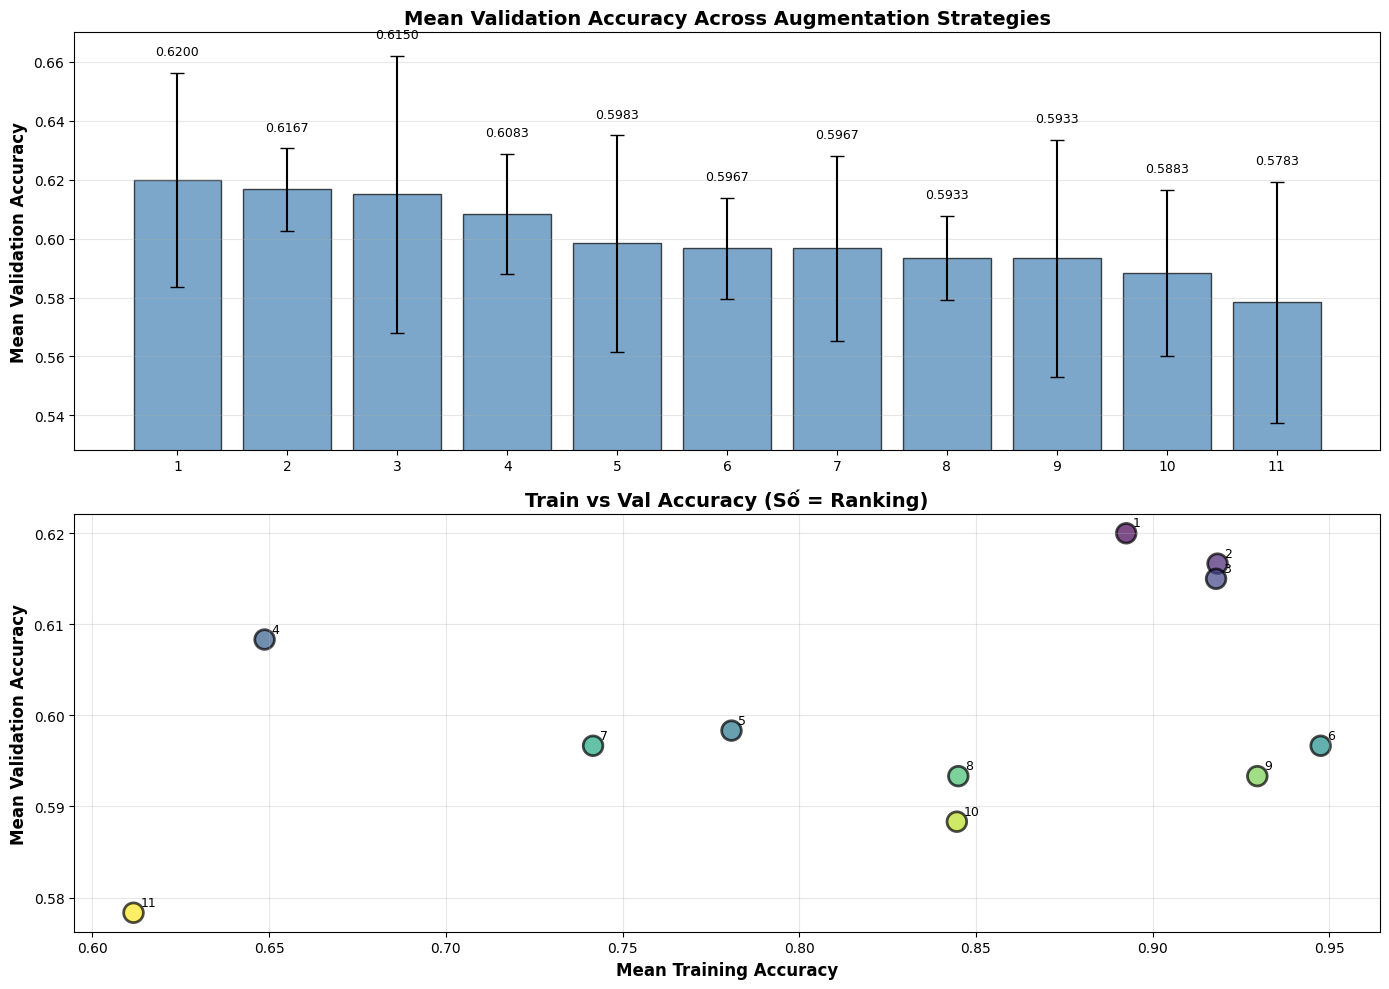

C:\Users\DANG KHOA\AppData\Local\Temp\ipykernel_2548\3743620377.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(fold_data, positions=positions, widths=0.6, patch_artist=True,


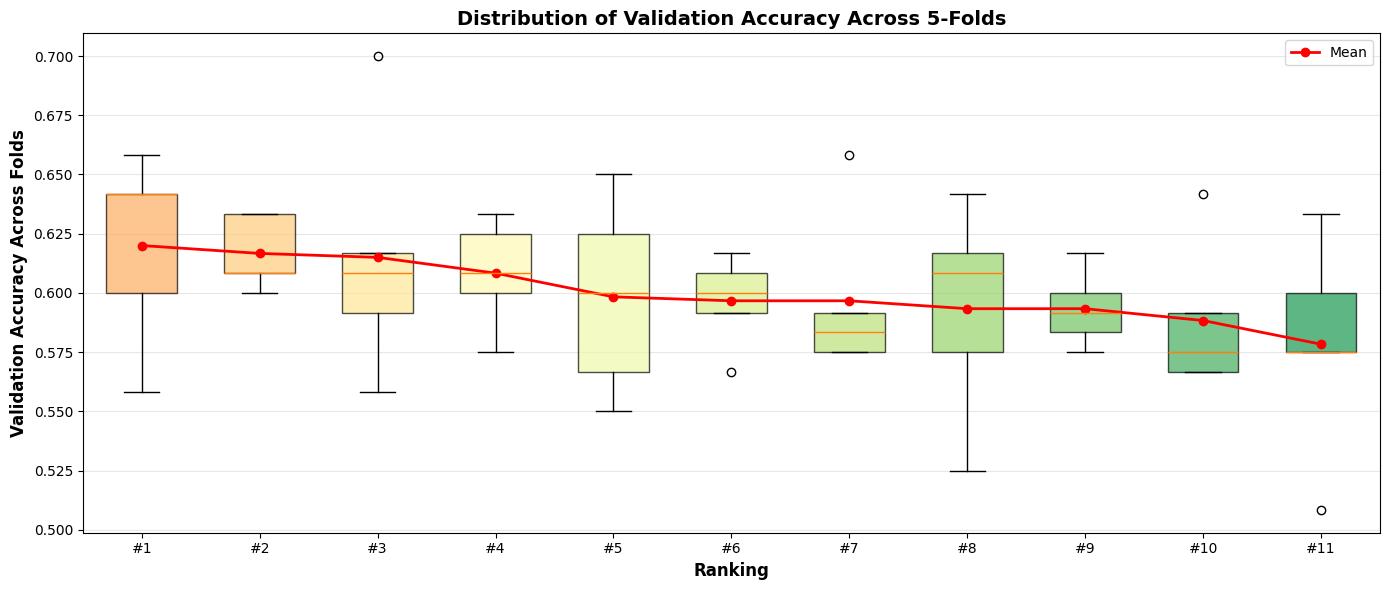

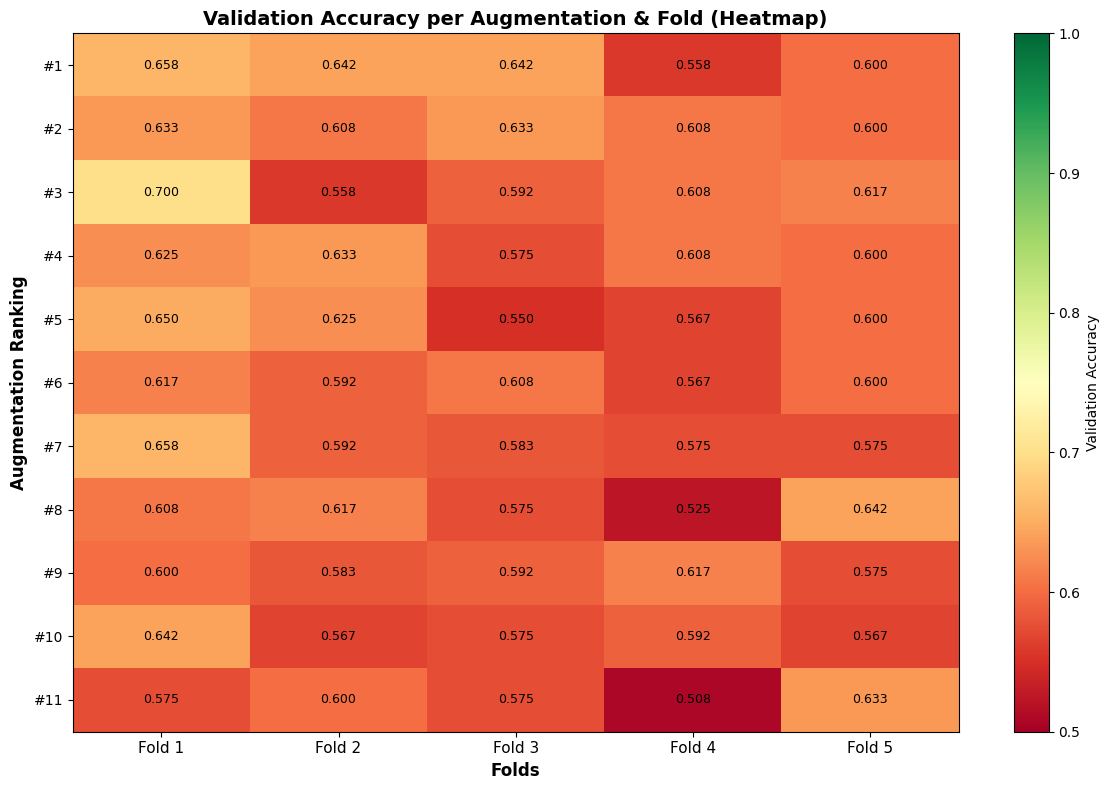


LEGEND:
# 1. HorizontalFlip + VerticalFlip                     
# 2. HorizontalFlip + ColorJitter_med                  
# 3. HorizontalFlip                                    
# 4. HorizontalFlip + VerticalFlip + Rotation15 + ColorJitter_med
# 5. HorizontalFlip + Rotation15 + ColorJitter_med     
# 6. ColorJitter_med                                   
# 7. HorizontalFlip + Rotation15 + ColorJitter_med + GaussianBlur
# 8. NO AUGMENTATION                                   
# 9. VerticalFlip                                      
#10. Rotation15                                        
#11. HorizontalFlip + VerticalFlip + Rotation30 + ColorJitter_heavy


In [30]:
# ============================================================================
# VISUALIZATION - SO SÁNH AUGMENTATION STRATEGIES
# ============================================================================

# Plot 1: Bar chart - Val Accuracy của mỗi augmentation
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

x_pos = np.arange(len(results_df))

# Val Accuracy with error bars
axes[0].bar(x_pos, results_df["Mean Val Acc"], 
           yerr=results_df["Std Val Acc"], 
           capsize=5, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_ylabel("Mean Validation Accuracy", fontsize=12, fontweight='bold')
axes[0].set_title("Mean Validation Accuracy Across Augmentation Strategies", fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(range(1, len(results_df)+1), fontsize=10)
axes[0].grid(True, axis='y', alpha=0.3)
axes[0].set_ylim([min(results_df["Mean Val Acc"]) - 0.05, max(results_df["Mean Val Acc"]) + 0.05])

# Thêm giá trị trên mỗi bar
for i, (idx, row) in enumerate(results_df.iterrows()):
    axes[0].text(i, row["Mean Val Acc"] + row["Std Val Acc"] + 0.005, 
                f'{row["Mean Val Acc"]:.4f}', ha='center', va='bottom', fontsize=9)

# Train vs Val Accuracy scatter
colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
axes[1].scatter(results_df["Mean Train Acc"], results_df["Mean Val Acc"], 
               s=200, c=range(len(results_df)), cmap='viridis', edgecolor='black', linewidth=2, alpha=0.7)

# Thêm annotation
for i, (idx, row) in enumerate(results_df.iterrows()):
    axes[1].annotate(f"{i+1}", 
                    xy=(row["Mean Train Acc"], row["Mean Val Acc"]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[1].set_xlabel("Mean Training Accuracy", fontsize=12, fontweight='bold')
axes[1].set_ylabel("Mean Validation Accuracy", fontsize=12, fontweight='bold')
axes[1].set_title("Train vs Val Accuracy (Số = Ranking)", fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: Boxplot - Phân bố accuracy trên các fold
fig, ax = plt.subplots(figsize=(14, 6))

# Tạo data cho boxplot
fold_data = [augmentation_results["all_fold_val_acc"][i] for i in np.argsort(augmentation_results["avg_val_acc"])[::-1]]
positions = np.arange(1, len(fold_data) + 1)

bp = ax.boxplot(fold_data, positions=positions, widths=0.6, patch_artist=True,
               labels=[f"#{i+1}" for i in range(len(fold_data))])

# Tô màu boxes
colors_box = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(fold_data)))
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel("Validation Accuracy Across Folds", fontsize=12, fontweight='bold')
ax.set_xlabel("Ranking", fontsize=12, fontweight='bold')
ax.set_title("Distribution of Validation Accuracy Across 5-Folds", fontsize=14, fontweight='bold')
ax.grid(True, axis='y', alpha=0.3)

# Thêm mean value
means = [np.mean(fold_data[i]) for i in range(len(fold_data))]
ax.plot(positions, means, 'ro-', linewidth=2, markersize=6, label='Mean')
ax.legend()

plt.tight_layout()
plt.show()

# Plot 3: Heatmap - Val Accuracy trên từng fold
fig, ax = plt.subplots(figsize=(12, 8))

# Tạo matrix: rows = augmentation (sorted), cols = folds
fold_matrix = np.array([augmentation_results["all_fold_val_acc"][i] for i in np.argsort(augmentation_results["avg_val_acc"])[::-1]])
aug_labels = [results_df.iloc[i]["Augmentation"] for i in range(len(results_df))]

im = ax.imshow(fold_matrix, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=1.0)

ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(len(aug_labels)))
ax.set_xticklabels([f"Fold {i+1}" for i in range(5)], fontsize=11)
ax.set_yticklabels([f"#{i+1}" for i in range(len(aug_labels))], fontsize=10)

ax.set_xlabel("Folds", fontsize=12, fontweight='bold')
ax.set_ylabel("Augmentation Ranking", fontsize=12, fontweight='bold')
ax.set_title("Validation Accuracy per Augmentation & Fold (Heatmap)", fontsize=14, fontweight='bold')

# Thêm text annotations
for i in range(len(aug_labels)):
    for j in range(5):
        text = ax.text(j, i, f'{fold_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im, ax=ax, label='Validation Accuracy')
plt.tight_layout()
plt.show()

# Print legend
print("\nLEGEND:")
for i, (idx, row) in enumerate(results_df.iterrows()):
    print(f"#{i+1:2d}. {row['Augmentation']:50s}")


In [31]:
# ============================================================================
# TIỂU KẾT + LƯU KẾT QUẢ
# ============================================================================

print("=" * 100)
print("TĨM TẮT KẾT QUẢ VÉT AUGMENTATION")
print("=" * 100)

best_idx = results_df["Mean Val Acc"].idxmax()
best_row = results_df.loc[best_idx]
baseline_row = results_df[results_df["Augmentation"] == "NO AUGMENTATION"].iloc[0]

print(f"\n✓ BEST AUGMENTATION: {best_row['Augmentation']}")
print(f"  Val Accuracy: {best_row['Mean Val Acc']:.4f} ± {best_row['Std Val Acc']:.4f}")
print(f"  Train Accuracy: {best_row['Mean Train Acc']:.4f}")

improvement = (best_row['Mean Val Acc'] - baseline_row['Mean Val Acc']) / baseline_row['Mean Val Acc'] * 100
print(f"\n✓ SO SÁNH VỚI BASELINE (NO AUGMENTATION):")
print(f"  Baseline Val Acc: {baseline_row['Mean Val Acc']:.4f} ± {baseline_row['Std Val Acc']:.4f}")
print(f"  Improvement: {improvement:+.2f}%")

print(f"\n✓ TỔNG SỐ AUGMENTATION ĐÃ TEST: {len(results_df)}")

# Lưu kết quả vào CSV
csv_path = os.path.join(CHECKPOINT_DIR, "augmentation_results.csv")
results_df.to_csv(csv_path, index=False)
print(f"\n✓ Kết quả đã lưu vào: {csv_path}")

# Lưu kết quả chi tiết vào JSON
json_path = os.path.join(CHECKPOINT_DIR, "augmentation_results_detailed.json")
json_results = {
    "augmentation_results": [
        {
            "augmentation": aug_combo,
            "avg_val_acc": float(augmentation_results["avg_val_acc"][i]),
            "std_val_acc": float(augmentation_results["std_val_acc"][i]),
            "avg_train_acc": float(augmentation_results["avg_train_acc"][i]),
            "fold_accs": [float(x) for x in augmentation_results["all_fold_val_acc"][i]]
        }
        for i, aug_combo in enumerate(augmentation_results["aug_combo"])
    ],
    "best_augmentation": best_row["Augmentation"],
    "best_val_acc": float(best_row["Mean Val Acc"]),
    "timestamp": datetime.now().isoformat()
}

with open(json_path, 'w') as f:
    json.dump(json_results, f, indent=2)
print(f"✓ Chi tiết kết quả đã lưu vào: {json_path}")

print("\n" + "=" * 100)


TĨM TẮT KẾT QUẢ VÉT AUGMENTATION

✓ BEST AUGMENTATION: HorizontalFlip + VerticalFlip
  Val Accuracy: 0.6200 ± 0.0364
  Train Accuracy: 0.8925

✓ SO SÁNH VỚI BASELINE (NO AUGMENTATION):
  Baseline Val Acc: 0.5933 ± 0.0143
  Improvement: +4.49%

✓ TỔNG SỐ AUGMENTATION ĐÃ TEST: 11

✓ Kết quả đã lưu vào: G:\My Drive\NCKH\git\checkpoints\augmentation_results.csv
✓ Chi tiết kết quả đã lưu vào: G:\My Drive\NCKH\git\checkpoints\augmentation_results_detailed.json



In [32]:
# ============================================================================
# CHỌN AUGMENTATION TỐT NHẤT + TRAINING FINAL + SUBMISSION
# ============================================================================

# Tự động chọn augmentation tốt nhất
best_augmentation = best_row["Augmentation"]
best_aug_combo = [a.strip() for a in best_augmentation.split('+')] if best_augmentation != "NO AUGMENTATION" else []

print(f"\n{'=' * 100}")
print(f"TRAINING FINAL MODEL VỚI BEST AUGMENTATION")
print(f"{'=' * 100}\n")

print(f"Selected Augmentation: {best_augmentation}")
print(f"Expected Val Accuracy: {best_row['Mean Val Acc']:.4f} ± {best_row['Std Val Acc']:.4f}\n")

# ============================================================================
# TRAINING FINAL MODEL - K-FOLD CROSS VALIDATION
# ============================================================================

print("=" * 100)
print("K-FOLD CROSS VALIDATION TRAINING WITH BEST AUGMENTATION")
print("=" * 100 + "\n")

# Create transforms with best augmentation
tfm_train_best = create_transforms_from_combo(best_aug_combo, CONFIG["img_size"])
tfm_val_best = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize results tracking
fold_results_final = {
    "fold": [],
    "train_acc": [],
    "val_acc": [],
    "train_loss": [],
    "val_loss": []
}

overall_best_val_acc_final = 0.0
best_fold_model_path_final = None

for fold_idx, (train_files, val_files) in enumerate(kfold_splits, 1):
    print(f"\n{'=' * 100}")
    print(f"FOLD {fold_idx}/{n_splits}")
    print(f"{'=' * 100}")
    
    # Create datasets for this fold
    train_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_train_best, file_list=train_files)
    val_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_val_best, file_list=val_files)
    
    # DataLoaders
    train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)
    
    print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")
    
    # Reinitialize model for each fold
    model = create_model(CONFIG["num_classes"], pretrained=True)
    model = model.to(device)
    
    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    
    # Training loop for this fold
    best_val_acc = 0.0
    best_train_acc_at_best_val = 0.0
    fold_model_path = os.path.join(CHECKPOINT_DIR, f"best_rgb_resnet18_fold{fold_idx}_final.pth")
    
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(1, CONFIG["epochs"] + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        scheduler.step(val_acc)
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_train_acc_at_best_val = train_acc
            torch.save(model.state_dict(), fold_model_path)
            print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f} ⭐")
        else:
            print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f}")
    
    # Save fold results
    fold_results_final["fold"].append(fold_idx)
    fold_results_final["train_loss"].append(history["train_loss"][-1])
    fold_results_final["train_acc"].append(history["train_acc"][-1])
    fold_results_final["val_loss"].append(history["val_loss"][-1])
    fold_results_final["val_acc"].append(history["val_acc"][-1])
    
    print(f"\n✓ Fold {fold_idx} Best val_acc: {best_val_acc:.4f}")
    print(f"✓ Model saved to: {fold_model_path}")
    
    # Track best model across all folds
    if best_val_acc > overall_best_val_acc_final:
        overall_best_val_acc_final = best_val_acc
        best_fold_model_path_final = fold_model_path
        best_fold_idx_final = fold_idx

# Print K-Fold Summary
print("\n" + "=" * 100)
print("K-FOLD CROSS VALIDATION SUMMARY - FINAL")
print("=" * 100)
for i in range(len(fold_results_final["fold"])):
    print(f"Fold {fold_results_final['fold'][i]}: val_acc={fold_results_final['val_acc'][i]:.4f}, train_acc={fold_results_final['train_acc'][i]:.4f}")

avg_val_acc_final = np.mean(fold_results_final["val_acc"])
std_val_acc_final = np.std(fold_results_final["val_acc"])
print(f"\nMean Val Accuracy: {avg_val_acc_final:.4f} ± {std_val_acc_final:.4f}")
print(f"Best Overall Val Accuracy: {overall_best_val_acc_final:.4f} (Fold {best_fold_idx_final})")
print(f"Best Model: {best_fold_model_path_final}")

print(f"\n✓ AUGMENTATION USED: {best_augmentation}")



TRAINING FINAL MODEL VỚI BEST AUGMENTATION

Selected Augmentation: HorizontalFlip + VerticalFlip
Expected Val Accuracy: 0.6200 ± 0.0364

K-FOLD CROSS VALIDATION TRAINING WITH BEST AUGMENTATION


FOLD 1/5
Train: 480, Val: 120
Epoch 01 | train_acc=0.4521 val_acc=0.5167 ⭐
Epoch 02 | train_acc=0.6062 val_acc=0.5750 ⭐
Epoch 03 | train_acc=0.7396 val_acc=0.5667
Epoch 04 | train_acc=0.8083 val_acc=0.5833 ⭐
Epoch 05 | train_acc=0.8250 val_acc=0.6250 ⭐
Epoch 06 | train_acc=0.8583 val_acc=0.6167
Epoch 07 | train_acc=0.9083 val_acc=0.5500
Epoch 08 | train_acc=0.8896 val_acc=0.5917
Epoch 09 | train_acc=0.9167 val_acc=0.5583
Epoch 10 | train_acc=0.9167 val_acc=0.5583

✓ Fold 1 Best val_acc: 0.6250
✓ Model saved to: G:\My Drive\NCKH\git\checkpoints\best_rgb_resnet18_fold1_final.pth

FOLD 2/5
Train: 480, Val: 120
Epoch 01 | train_acc=0.4208 val_acc=0.5083 ⭐
Epoch 02 | train_acc=0.6125 val_acc=0.5750 ⭐
Epoch 03 | train_acc=0.7417 val_acc=0.6417 ⭐
Epoch 04 | train_acc=0.7750 val_acc=0.6250
Epoch 05 | 

In [33]:
def create_model(num_classes, pretrained=True):
    """Create ResNet18 model with custom FC layer"""
    if pretrained:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        model = models.resnet18(weights=None)
    
    # Replace final FC layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

model = create_model(CONFIG["num_classes"], pretrained=True)
model = model.to(device)

print(f"Model: {CONFIG['model_name']}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Model: resnet18
Parameters: 11,178,051


## 5. Training

In [34]:
def train_one_epoch(model, loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    """Evaluate model"""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total

In [35]:
# K-Fold Cross Validation Training
print("\n" + "="*60)
print("K-FOLD CROSS VALIDATION TRAINING")
print("="*60 + "\n")

overall_best_val_acc = 0.0
best_fold_model_path = None

for fold_idx, (train_files, val_files) in enumerate(kfold_splits, 1):
    print(f"\n{'='*60}")
    print(f"FOLD {fold_idx}/{n_splits}")
    print(f"{'='*60}")
    
    # Initialize WandB for this fold
    wandb.init(
        project="beyond-visible-spectrum",
        name=f"baseline_rgb_{CONFIG['model_name']}_fold{fold_idx}",
        config=CONFIG
    )
    
    # Create datasets for this fold
    train_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_train, file_list=train_files)
    val_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_val, file_list=val_files)
    
    # DataLoaders
    train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)
    
    print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")
    
    # Reinitialize model for each fold
    model = create_model(CONFIG["num_classes"], pretrained=True)
    model = model.to(device)
    
    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    
    # Training loop for this fold
    best_val_acc = 0.0
    fold_model_path = os.path.join(CHECKPOINT_DIR, f"best_rgb_resnet18_fold{fold_idx}.pth")
    
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(1, CONFIG["epochs"] + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        scheduler.step(val_acc)
        
        wandb.log({
            "epoch": epoch,
            "fold": fold_idx,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "lr": optimizer.param_groups[0]['lr']
        })
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), fold_model_path)
            print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f} ⭐")
        else:
            print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f}")
    
    wandb.finish()
    
    # Save fold results
    fold_results["fold"].append(fold_idx)
    fold_results["train_loss"].append(history["train_loss"][-1])
    fold_results["train_acc"].append(history["train_acc"][-1])
    fold_results["val_loss"].append(history["val_loss"][-1])
    fold_results["val_acc"].append(history["val_acc"][-1])
    
    print(f"\n✓ Fold {fold_idx} Best val_acc: {best_val_acc:.4f}")
    print(f"✓ Model saved to: {fold_model_path}")
    
    # Track best model across all folds
    if best_val_acc > overall_best_val_acc:
        overall_best_val_acc = best_val_acc
        best_fold_model_path = fold_model_path

# Print K-Fold Summary
print("\n" + "="*60)
print("K-FOLD CROSS VALIDATION SUMMARY")
print("="*60)
for i in range(len(fold_results["fold"])):
    print(f"Fold {fold_results['fold'][i]}: val_acc={fold_results['val_acc'][i]:.4f}, train_acc={fold_results['train_acc'][i]:.4f}")

avg_val_acc = np.mean(fold_results["val_acc"])
std_val_acc = np.std(fold_results["val_acc"])
print(f"\nMean Val Accuracy: {avg_val_acc:.4f} ± {std_val_acc:.4f}")
print(f"Best Overall Val Accuracy: {overall_best_val_acc:.4f}")
print(f"Best Model: {best_fold_model_path}")


K-FOLD CROSS VALIDATION TRAINING


FOLD 1/5


Train: 480, Val: 120
Epoch 01 | train_acc=0.4417 val_acc=0.5917 ⭐
Epoch 02 | train_acc=0.5667 val_acc=0.5917
Epoch 03 | train_acc=0.5771 val_acc=0.6167 ⭐
Epoch 04 | train_acc=0.6229 val_acc=0.5583
Epoch 05 | train_acc=0.6417 val_acc=0.5667
Epoch 06 | train_acc=0.6687 val_acc=0.6333 ⭐
Epoch 07 | train_acc=0.7104 val_acc=0.5333
Epoch 08 | train_acc=0.6813 val_acc=0.5667
Epoch 09 | train_acc=0.7167 val_acc=0.6333


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 10 | train_acc=0.7229 val_acc=0.6250


epoch,▁▂▃▃▄▅▆▆▇█
fold,▁▁▁▁▁▁▁▁▁▁
lr,█████████▁
train_acc,▁▄▄▆▆▇█▇██
train_loss,█▅▅▄▃▃▂▂▂▁
val_acc,▅▅▇▃▃█▁▃█▇
val_loss,█▅▄▃▁▁▃▃▂▂
epoch,10
fold,1
lr,5e-05
train_acc,0.72292



✓ Fold 1 Best val_acc: 0.6333
✓ Model saved to: G:\My Drive\NCKH\git\checkpoints\best_rgb_resnet18_fold1.pth

FOLD 2/5


Train: 480, Val: 120
Epoch 01 | train_acc=0.4125 val_acc=0.5333 ⭐
Epoch 02 | train_acc=0.5750 val_acc=0.5500 ⭐
Epoch 03 | train_acc=0.6062 val_acc=0.5500
Epoch 04 | train_acc=0.6562 val_acc=0.5083
Epoch 05 | train_acc=0.6687 val_acc=0.5750 ⭐
Epoch 06 | train_acc=0.6833 val_acc=0.5167
Epoch 07 | train_acc=0.6875 val_acc=0.5750
Epoch 08 | train_acc=0.7229 val_acc=0.5333
Epoch 09 | train_acc=0.6979 val_acc=0.5083


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 10 | train_acc=0.7771 val_acc=0.5500


epoch,▁▂▃▃▄▅▆▆▇█
fold,▁▁▁▁▁▁▁▁▁▁
lr,████████▁▁
train_acc,▁▄▅▆▆▆▆▇▆█
train_loss,█▅▄▃▃▃▂▂▂▁
val_acc,▄▅▅▁█▂█▄▁▅
val_loss,▃▂▆█▇▃▃▇▄▁
epoch,10
fold,2
lr,5e-05
train_acc,0.77708



✓ Fold 2 Best val_acc: 0.5750
✓ Model saved to: G:\My Drive\NCKH\git\checkpoints\best_rgb_resnet18_fold2.pth

FOLD 3/5


Train: 480, Val: 120
Epoch 01 | train_acc=0.4229 val_acc=0.5333 ⭐
Epoch 02 | train_acc=0.5708 val_acc=0.5583 ⭐
Epoch 03 | train_acc=0.5875 val_acc=0.6167 ⭐
Epoch 04 | train_acc=0.6042 val_acc=0.5917
Epoch 05 | train_acc=0.6354 val_acc=0.5583
Epoch 06 | train_acc=0.6750 val_acc=0.6000
Epoch 07 | train_acc=0.6771 val_acc=0.6000
Epoch 08 | train_acc=0.7271 val_acc=0.5750
Epoch 09 | train_acc=0.7250 val_acc=0.6250 ⭐


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 10 | train_acc=0.7125 val_acc=0.6083


epoch,▁▂▃▃▄▅▆▆▇█
fold,▁▁▁▁▁▁▁▁▁▁
lr,██████▁▁▁▁
train_acc,▁▄▅▅▆▇▇███
train_loss,█▅▅▄▃▃▂▁▁▁
val_acc,▁▃▇▅▃▆▆▄█▇
val_loss,█▅▄▁▂▁▅▃▂▂
epoch,10
fold,3
lr,5e-05
train_acc,0.7125



✓ Fold 3 Best val_acc: 0.6250
✓ Model saved to: G:\My Drive\NCKH\git\checkpoints\best_rgb_resnet18_fold3.pth

FOLD 4/5


Train: 480, Val: 120
Epoch 01 | train_acc=0.4667 val_acc=0.5083 ⭐
Epoch 02 | train_acc=0.6062 val_acc=0.5250 ⭐
Epoch 03 | train_acc=0.6042 val_acc=0.4917
Epoch 04 | train_acc=0.6604 val_acc=0.4917
Epoch 05 | train_acc=0.6687 val_acc=0.4833
Epoch 06 | train_acc=0.7021 val_acc=0.5333 ⭐
Epoch 07 | train_acc=0.7042 val_acc=0.5250
Epoch 08 | train_acc=0.7083 val_acc=0.5333
Epoch 09 | train_acc=0.7188 val_acc=0.5250


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 10 | train_acc=0.7188 val_acc=0.5417 ⭐


epoch,▁▂▃▃▄▅▆▆▇█
fold,▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁
train_acc,▁▅▅▆▇█████
train_loss,█▄▄▃▃▂▂▂▁▁
val_acc,▄▆▂▂▁▇▆▇▆█
val_loss,█▁▂▃▄▄▁▂▂▃
epoch,10
fold,4
lr,0.0001
train_acc,0.71875



✓ Fold 4 Best val_acc: 0.5417
✓ Model saved to: G:\My Drive\NCKH\git\checkpoints\best_rgb_resnet18_fold4.pth

FOLD 5/5


Train: 480, Val: 120
Epoch 01 | train_acc=0.4208 val_acc=0.5250 ⭐
Epoch 02 | train_acc=0.5458 val_acc=0.4917
Epoch 03 | train_acc=0.6250 val_acc=0.5167
Epoch 04 | train_acc=0.6417 val_acc=0.5083
Epoch 05 | train_acc=0.6458 val_acc=0.5167
Epoch 06 | train_acc=0.6854 val_acc=0.5417 ⭐
Epoch 07 | train_acc=0.7083 val_acc=0.5417
Epoch 08 | train_acc=0.7188 val_acc=0.5417
Epoch 09 | train_acc=0.7042 val_acc=0.5500 ⭐


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 10 | train_acc=0.7021 val_acc=0.5667 ⭐


epoch,▁▂▃▃▄▅▆▆▇█
fold,▁▁▁▁▁▁▁▁▁▁
lr,████▁▁▁▁▁▁
train_acc,▁▄▆▆▆▇████
train_loss,█▅▃▃▃▂▁▁▁▁
val_acc,▄▁▃▃▃▆▆▆▆█
val_loss,█▇▄▅▆▄▁▁▁▃
epoch,10
fold,5
lr,5e-05
train_acc,0.70208



✓ Fold 5 Best val_acc: 0.5667
✓ Model saved to: G:\My Drive\NCKH\git\checkpoints\best_rgb_resnet18_fold5.pth

K-FOLD CROSS VALIDATION SUMMARY
Fold 1: val_acc=0.5500, train_acc=0.7458
Fold 2: val_acc=0.5417, train_acc=0.7208
Fold 3: val_acc=0.5583, train_acc=0.7625
Fold 4: val_acc=0.6000, train_acc=0.7312
Fold 5: val_acc=0.5750, train_acc=0.7771
Fold 1: val_acc=0.6250, train_acc=0.7229
Fold 2: val_acc=0.5500, train_acc=0.7771
Fold 3: val_acc=0.6083, train_acc=0.7125
Fold 4: val_acc=0.5417, train_acc=0.7188
Fold 5: val_acc=0.5667, train_acc=0.7021

Mean Val Accuracy: 0.5717 ± 0.0282
Best Overall Val Accuracy: 0.6333
Best Model: G:\My Drive\NCKH\git\checkpoints\best_rgb_resnet18_fold1.pth


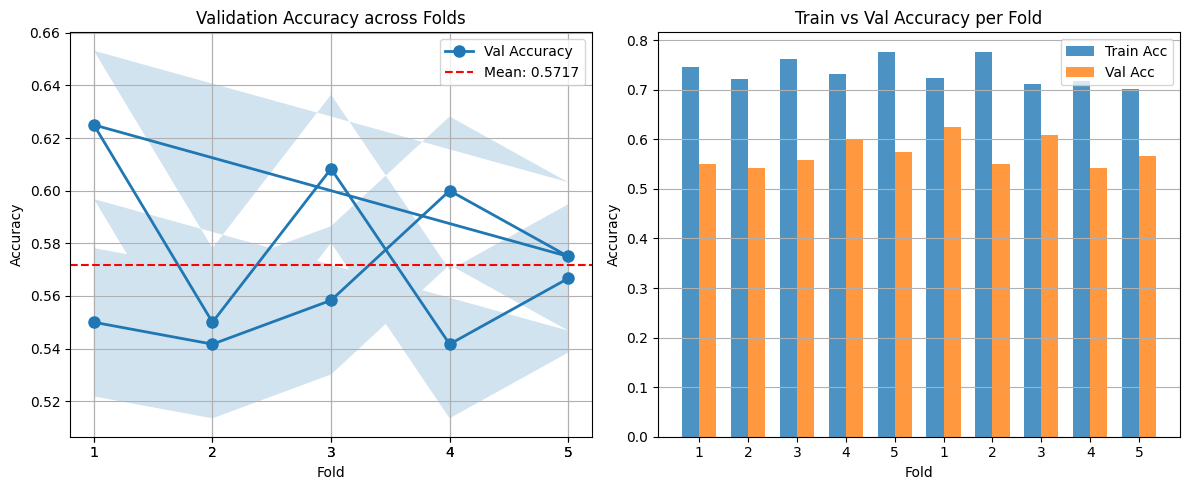

In [36]:
# Plot K-Fold Results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

folds = fold_results["fold"]

# Val Accuracy across folds
axes[0].plot(folds, fold_results["val_acc"], marker='o', label="Val Accuracy", linewidth=2, markersize=8)
axes[0].axhline(y=np.mean(fold_results["val_acc"]), color='r', linestyle='--', label=f'Mean: {np.mean(fold_results["val_acc"]):.4f}')
axes[0].fill_between(folds, 
                      np.array(fold_results["val_acc"]) - np.std(fold_results["val_acc"]),
                      np.array(fold_results["val_acc"]) + np.std(fold_results["val_acc"]),
                      alpha=0.2)
axes[0].set_xlabel("Fold")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Validation Accuracy across Folds")
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(folds)

# Train vs Val accuracy for each fold
x = np.arange(len(folds))
width = 0.35
axes[1].bar(x - width/2, fold_results["train_acc"], width, label="Train Acc", alpha=0.8)
axes[1].bar(x + width/2, fold_results["val_acc"], width, label="Val Acc", alpha=0.8)
axes[1].set_xlabel("Fold")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Train vs Val Accuracy per Fold")
axes[1].set_xticks(x)
axes[1].set_xticklabels(folds)
axes[1].legend()
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

## 6. Evaluation

In [37]:
# Load best model from best fold for evaluation
# Find which fold had the best model
best_fold_idx = fold_results["val_acc"].index(max(fold_results["val_acc"])) + 1
best_train_files, best_val_files = kfold_splits[best_fold_idx - 1]

# Recreate best fold's validation dataset
val_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_val, file_list=best_val_files)
val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)

print(f"\n{'='*60}")
print(f"EVALUATION on Best Fold ({best_fold_idx})")
print(f"Val samples: {len(val_ds)}")
print(f"{'='*60}\n")

# Load best model
model = create_model(CONFIG["num_classes"], pretrained=True)
model = model.to(device)
model.load_state_dict(torch.load(best_fold_model_path, map_location=device))
model.eval()

# Get predictions on validation set
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
class_names = [val_ds.idx_to_class[i] for i in range(CONFIG["num_classes"])]
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

IndexError: list index out of range

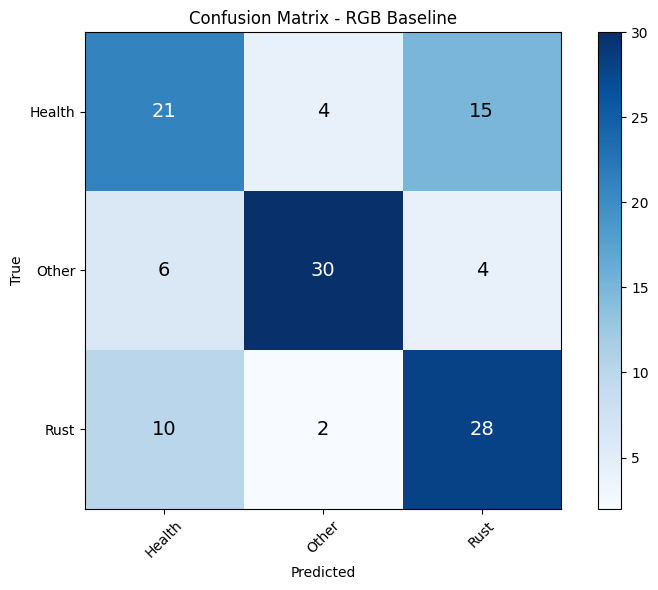

In [38]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RGB Baseline")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

=== Collecting Misclassified Images ===

Total misclassified: 52

Breakdown by type:
  Health → Other: 8 images
  Health → Rust: 15 images
  Other → Health: 7 images
  Other → Rust: 4 images
  Rust → Health: 16 images
  Rust → Other: 2 images

=== Visualizing Misclassified Images ===



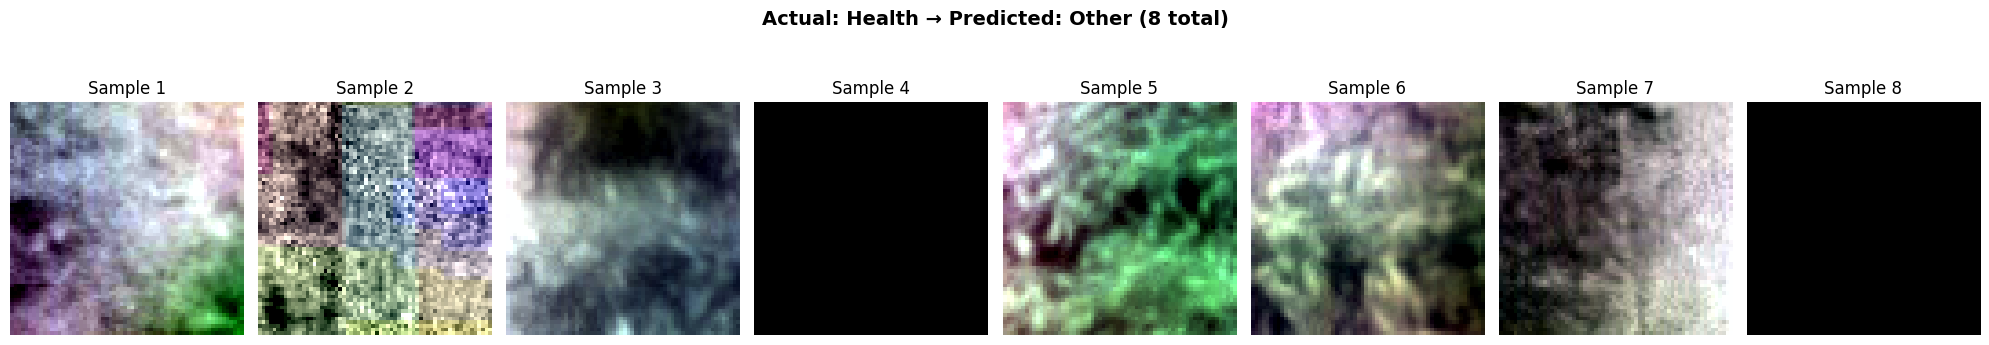

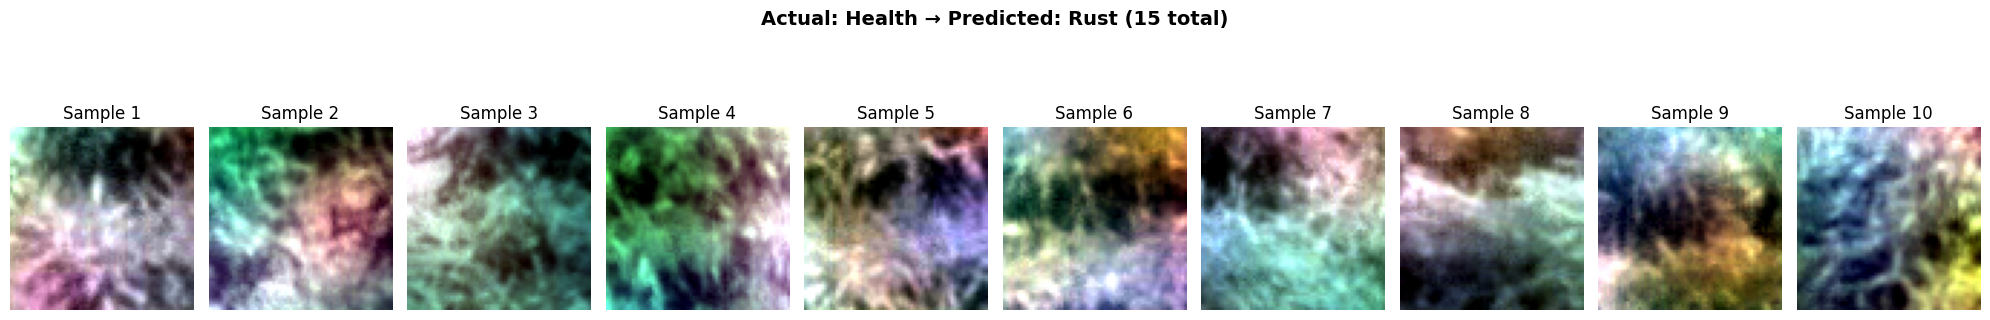

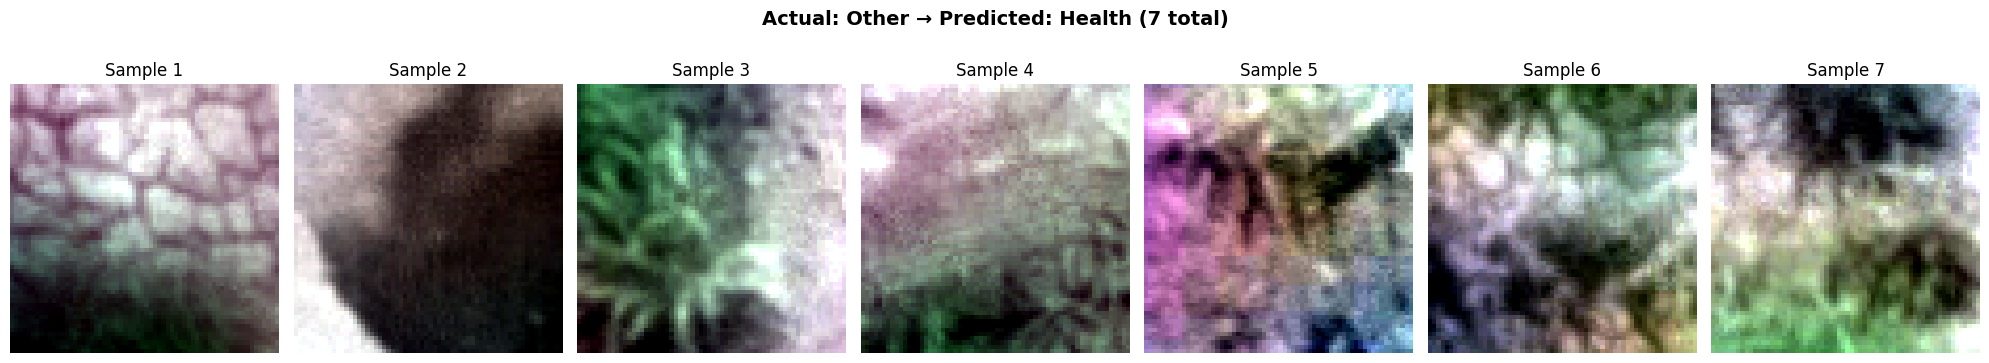

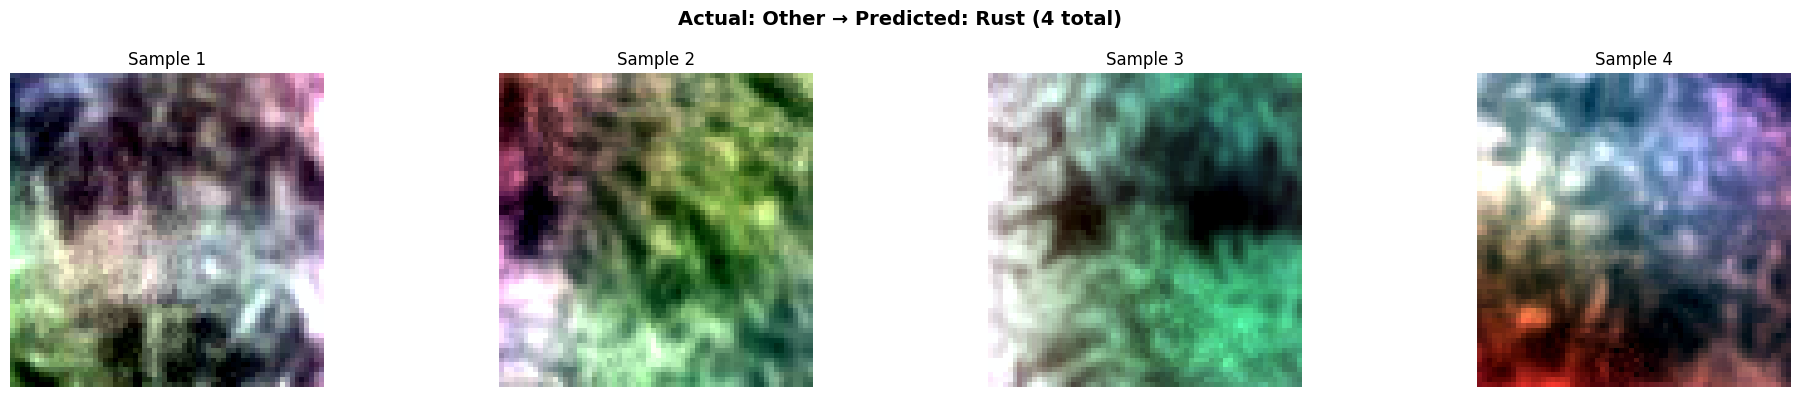

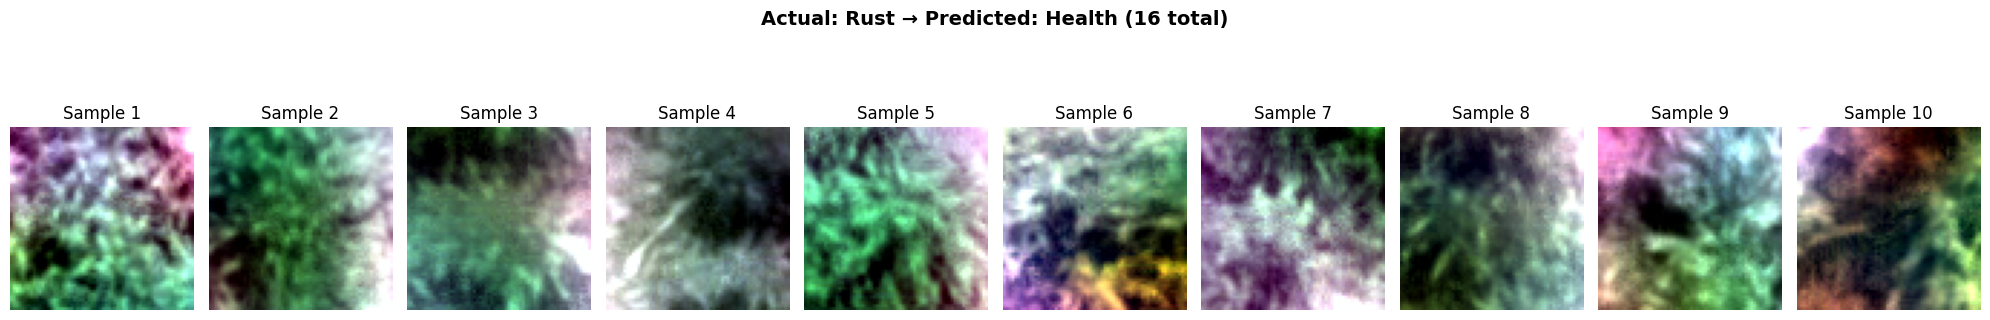

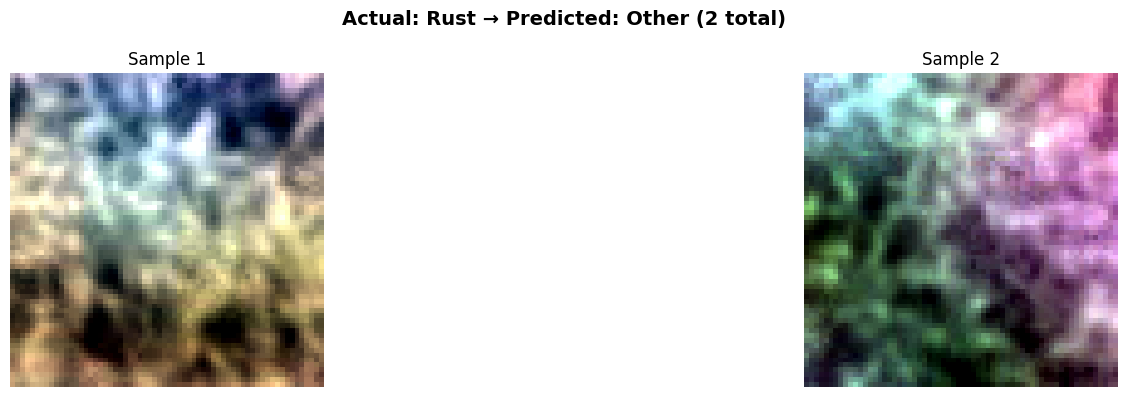

In [39]:
# Visualize Misclassified Images with proper denormalization
from collections import defaultdict

# Get predictions with image indices
misclassified = defaultdict(list)

print("=== Collecting Misclassified Images ===\n")

with torch.no_grad():
    val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
    
    for idx, (images, labels) in enumerate(val_dl):
        images = images.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1).cpu().numpy()[0]
        true = labels.numpy()[0]
        
        if pred != true:
            true_label = val_ds.idx_to_class[true]
            pred_label = val_ds.idx_to_class[pred]
            misclassified[(true_label, pred_label)].append(idx)

print(f"Total misclassified: {sum(len(v) for v in misclassified.values())}")
print("\nBreakdown by type:")
for (true_lbl, pred_lbl), indices in sorted(misclassified.items()):
    print(f"  {true_lbl} → {pred_lbl}: {len(indices)} images")

# Denormalization constants
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

def denormalize_image(img_tensor):
    """Denormalize ImageNet-normalized image tensor"""
    img_np = img_tensor.numpy().transpose(1, 2, 0)
    img_np = img_np * IMAGENET_STD + IMAGENET_MEAN
    img_np = np.clip(img_np, 0, 1)
    return img_np

# Visualize
print("\n=== Visualizing Misclassified Images ===\n")

for (true_lbl, pred_lbl), indices in sorted(misclassified.items()):
    num_show = min(10, len(indices))
    fig, axes = plt.subplots(1, num_show, figsize=(20, 4))
    
    if num_show == 1:
        axes = [axes]
    
    fig.suptitle(f"Actual: {true_lbl} → Predicted: {pred_lbl} ({len(indices)} total)", 
                 fontsize=14, fontweight='bold')
    
    for i, idx in enumerate(indices[:num_show]):
        img_tensor, _ = val_ds[idx]
        img_display = denormalize_image(img_tensor)
        
        axes[i].imshow(img_display)
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


ANALYSIS: Health (Thực tế) → Rust (Dự đoán)

Tổng cộng: 15 ảnh Health dự đoán sai thành Rust



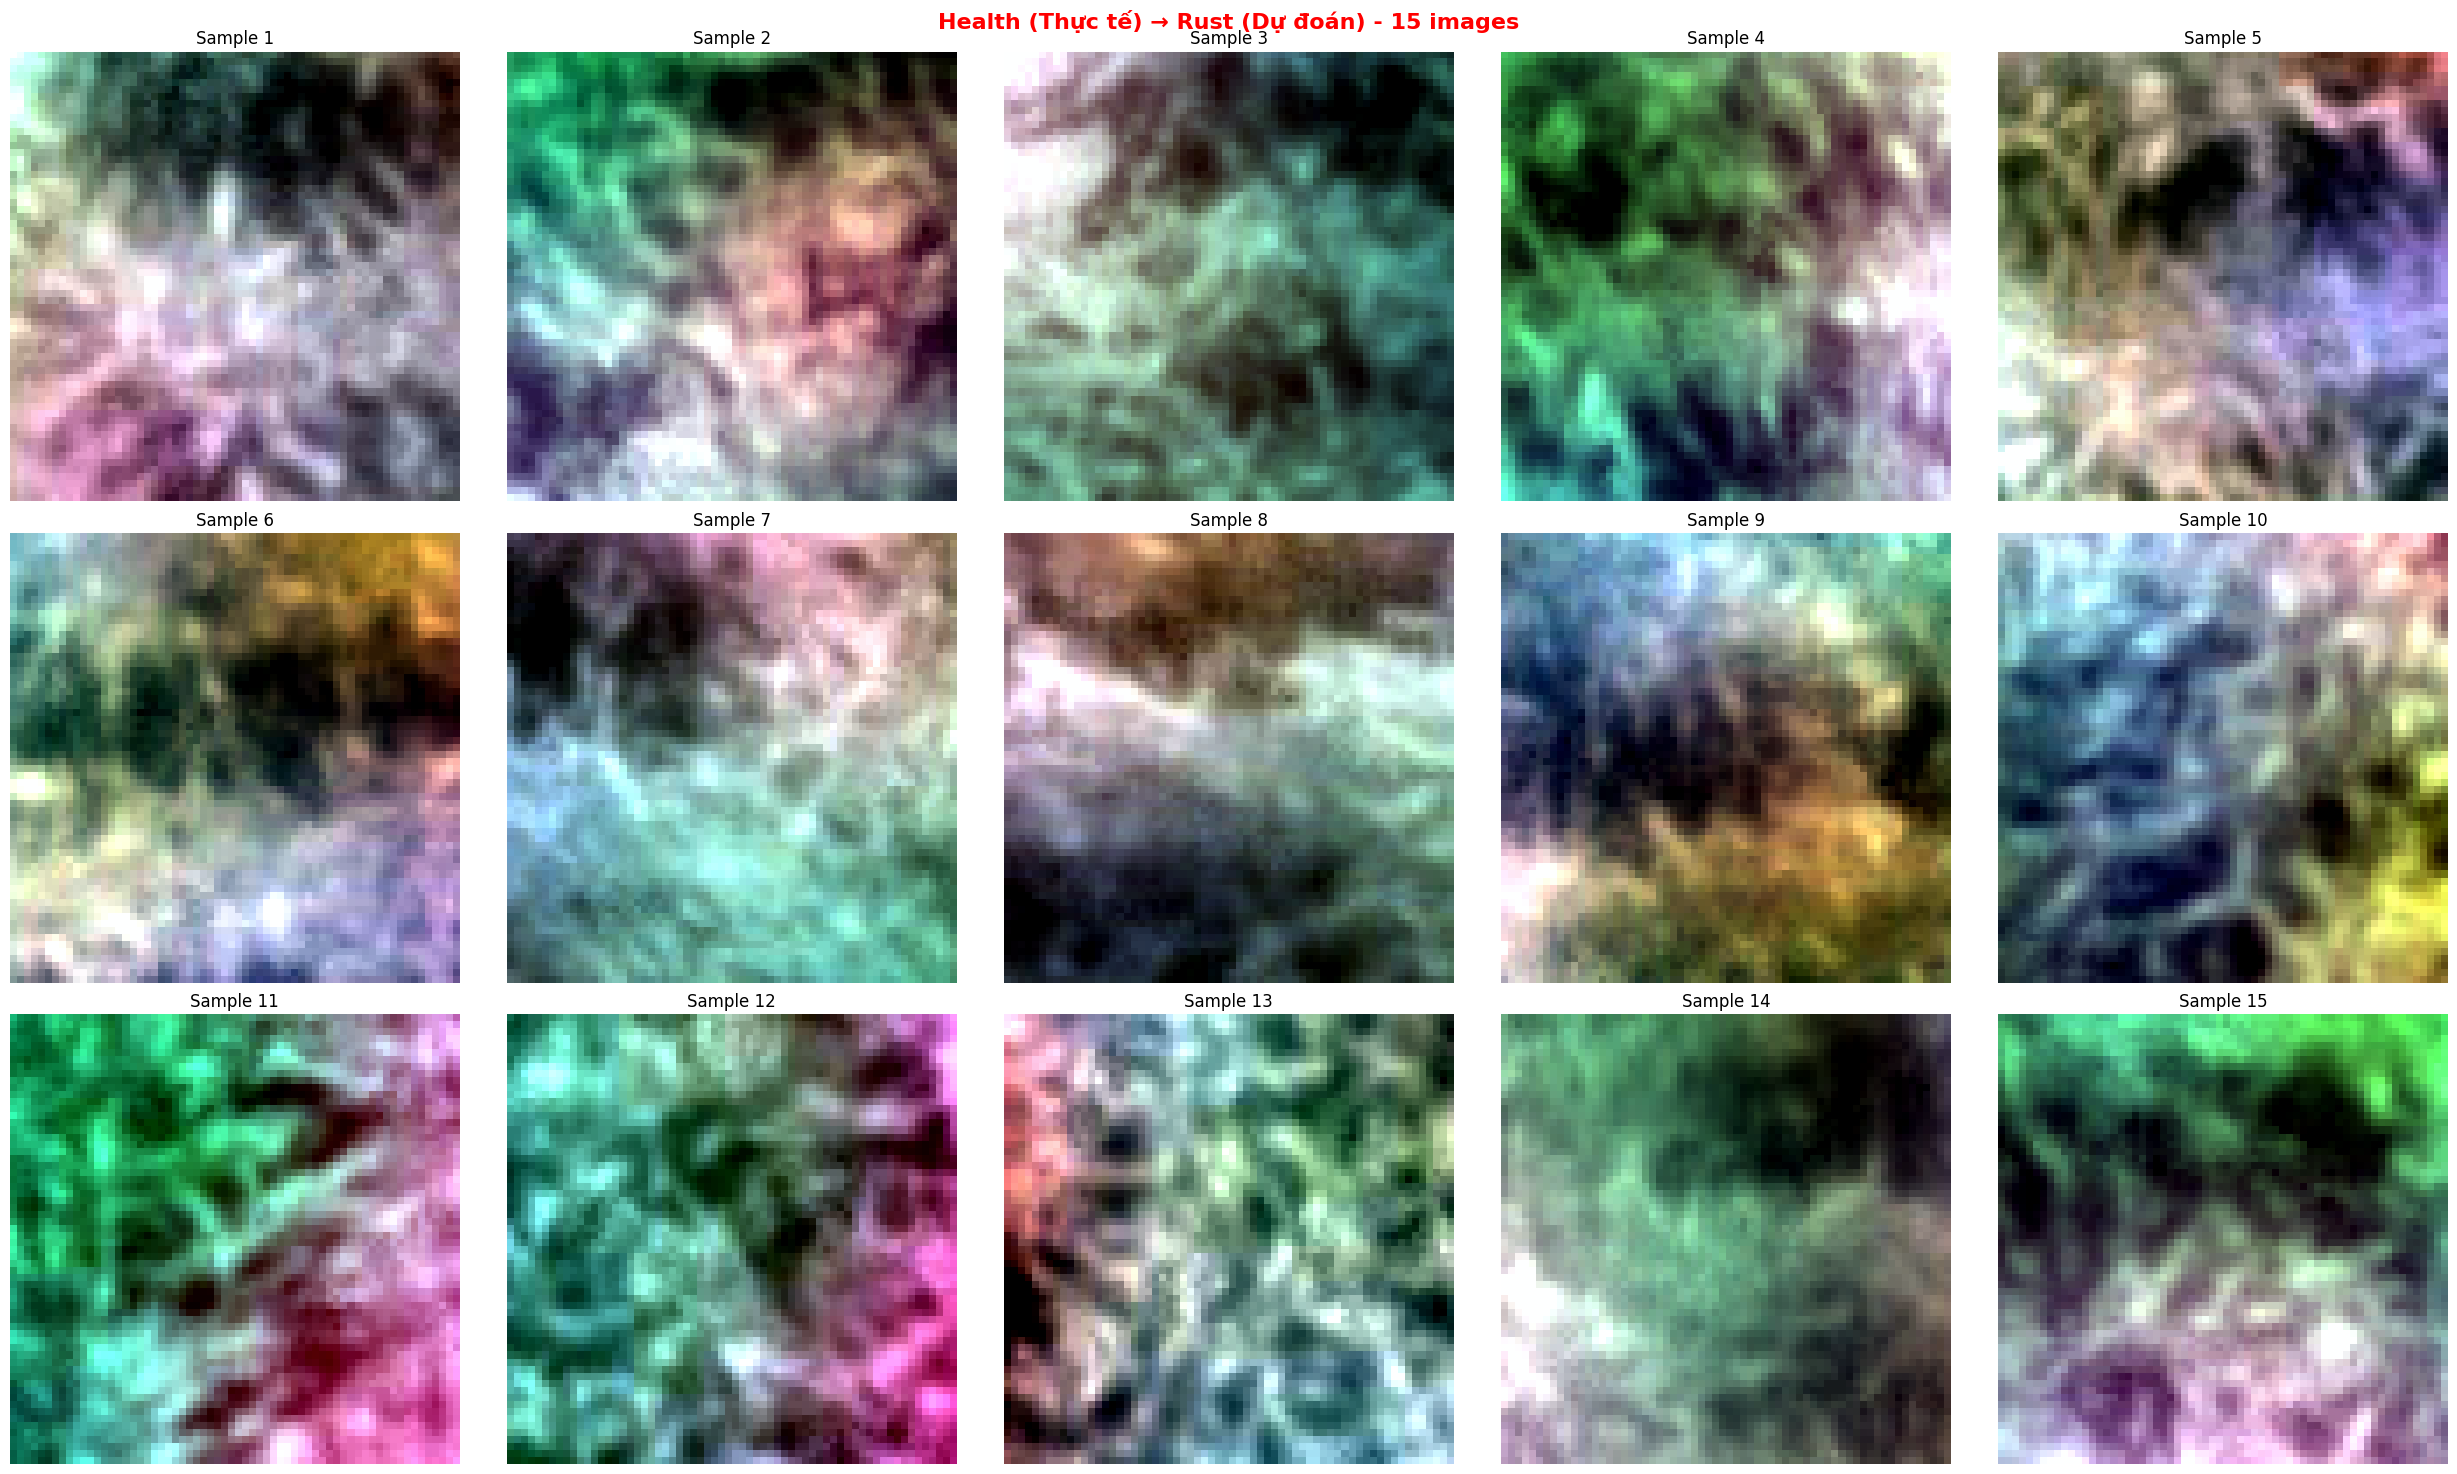

✓ Hiển thị 15 ảnh mẫu từ 15 tổng cộng


In [40]:
import math
# Visualize specific misclassification: Health → Rust
print("=" * 60)
print("ANALYSIS: Health (Thực tế) → Rust (Dự đoán)")
print("=" * 60)

true_lbl, pred_lbl = "Health", "Rust"

if (true_lbl, pred_lbl) in misclassified:
    indices = misclassified[(true_lbl, pred_lbl)]
    num_show = min(29, len(indices))
    
    print(f"\nTổng cộng: {len(indices)} ảnh Health dự đoán sai thành Rust\n")
    
    cols = 5
    rows = math.ceil(num_show / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.flatten()
    
    fig.suptitle(f"Health (Thực tế) → Rust (Dự đoán) - {len(indices)} images", 
                 fontsize=16, fontweight='bold', color='red')
    
    for i, idx in enumerate(indices[:num_show]):
        img_tensor, _ = val_ds[idx]
        img_display = denormalize_image(img_tensor)
        
        axes[i].imshow(img_display)
        axes[i].set_title(f"Sample {i+1}", fontsize=12)
        axes[i].axis('off')
    
    # Hide extra subplots
    for i in range(num_show, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Hiển thị {num_show} ảnh mẫu từ {len(indices)} tổng cộng")
else:
    print(f"❌ Không tìm thấy misclassification: {true_lbl} → {pred_lbl}")


## 7. Inference & Submission

In [41]:
# Check if test directory exists
if os.path.exists(TEST_RGB_DIR):
    # Create test dataset
    test_ds = RGBTestDataset(TEST_RGB_DIR, transform=tfm_val)
    test_loader = DataLoader(test_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)
    
    print(f"Test samples: {len(test_ds)}")
else:
    print(f"⚠️ Test directory not found: {TEST_RGB_DIR}")
    print("Skipping test inference...")

Test samples: 300


In [42]:
# Run inference on test set
if os.path.exists(TEST_RGB_DIR):
    model.eval()
    predictions = []
    filenames = []
    
    idx_to_class = val_ds.idx_to_class
    
    with torch.no_grad():
        for images, fnames in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            
            # Convert to class names
            pred_labels = [idx_to_class[p] for p in preds]
            
            predictions.extend(pred_labels)
            filenames.extend(fnames)
    
    print(f"✓ Predicted {len(predictions)} test samples")
    print(f"Sample predictions: {list(zip(filenames[:5], predictions[:5]))}")

✓ Predicted 300 test samples
Sample predictions: [('val_000a83c1.png', 'Health'), ('val_00a704b1.png', 'Health'), ('val_01dde030.png', 'Health'), ('val_024df365.png', 'Rust'), ('val_02afcb0e.png', 'Health')]


In [ ]:
# import pandas as pd

# df = pd.read_csv(r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\submission_task1_rgb.csv")

# label_map = {
#     "rust": "Rust",
#     "other": "Other",
#     "healthy": "Health"
# }

# df["label"] = df["label"].map(label_map)

# df.to_csv("submission_task1_rgb_FIXED.csv", index=False)
# print(df.head())


In [43]:
import os
import pandas as pd

if os.path.exists(TEST_RGB_DIR):
    submission_df = pd.DataFrame({
        "ID": filenames,      # TÊN CỘT ĐÚNG
        "label": predictions        # Rust / Other / Health
    })

    # sort cho đẹp (không bắt buộc nhưng nên làm)
    submission_df = submission_df.sort_values("ID").reset_index(drop=True)

    submission_path = os.path.join(CHECKPOINT_DIR, "submission_rgb.csv")
    submission_df.to_csv(submission_path, index=False)

    print(f"✓ Saved submission to: {submission_path}")
    print(f"✓ Total predictions: {len(submission_df)}")

    print("\nFirst 10 rows:")
    print(submission_df.head(10))

    print("\nLabel distribution:")
    print(submission_df["label"].value_counts())
else:
    print("⚠️ No test data - submission not created")


✓ Saved submission to: G:\My Drive\NCKH\git\checkpoints\submission_rgb.csv
✓ Total predictions: 300

First 10 rows:
                 ID   label
0  val_000a83c1.png  Health
1  val_00a704b1.png  Health
2  val_01dde030.png  Health
3  val_024df365.png    Rust
4  val_02afcb0e.png  Health
5  val_03864ba6.png    Rust
6  val_0537e324.png  Health
7  val_059983e0.png  Health
8  val_05cee914.png   Other
9  val_07af871a.png    Rust

Label distribution:
label
Rust      126
Other      94
Health     80
Name: count, dtype: int64


## 8. Overfitting Analysis (Optional)

In [44]:
# import pandas as pd

# # Giả sử submission_df là dataframe cũ của bạn
# submission_df = pd.DataFrame({
#     'Id': filenames,         # Đổi từ 'filename' sang 'Id'
#     'Category': formatted_labels  # Đổi từ 'label' sang 'Category' (kiểm tra lại tên cột này của BTC)
# })

# # Lưu file mới
# submission_df.to_csv('submission_task1_final.csv', index=False)

In [45]:
# Check for potential overfitting signs
print("=== Overfitting Analysis ===")
print(f"\nDataset size: {len(base_ds)} images")
print(f"Train/Val split: {len(train_ds)}/{len(val_ds)}")

# Gap between train and val accuracy
final_train_acc = history["train_acc"][-1]
final_val_acc = history["val_acc"][-1]
gap = final_train_acc - final_val_acc

print(f"\nFinal Train Accuracy: {final_train_acc:.4f}")
print(f"Final Val Accuracy: {final_val_acc:.4f}")
print(f"Gap (Train - Val): {gap:.4f}")

if gap > 0.1:
    print("⚠️ Large gap detected - possible overfitting!")
    print("   Suggestions: More augmentation, dropout, early stopping")
elif final_val_acc > 0.95:
    print("⚠️ Very high val_acc - check for data leakage!")
else:
    print("✓ Gap looks reasonable")

=== Overfitting Analysis ===

Dataset size: 600 images
Train/Val split: 480/120

Final Train Accuracy: 0.7021
Final Val Accuracy: 0.5667
Gap (Train - Val): 0.1354
⚠️ Large gap detected - possible overfitting!
   Suggestions: More augmentation, dropout, early stopping


=== Re-predicting Misclassified Images ===

Total misclassified images: 52

Top 10 Most Confident Misclassified Predictions:
----------------------------------------------------------------------------------------------------
1. Image: Health_hyper_109.png
   True Label: Health
   Predicted: Other (Confidence: 0.9995)
   Top-3 Predictions:
      1. Other: 0.9995
      2. Health: 0.0004
      3. Rust: 0.0001

2. Image: Rust_hyper_47.png
   True Label: Rust
   Predicted: Health (Confidence: 0.9969)
   Top-3 Predictions:
      1. Health: 0.9969
      2. Other: 0.0018
      3. Rust: 0.0013

3. Image: Rust_hyper_181.png
   True Label: Rust
   Predicted: Health (Confidence: 0.9760)
   Top-3 Predictions:
      1. Health: 0.9760
      2. Rust: 0.0233
      3. Other: 0.0007

4. Image: Health_hyper_105.png
   True Label: Health
   Predicted: Rust (Confidence: 0.9450)
   Top-3 Predictions:
      1. Rust: 0.9450
      2. Health: 0.0529
      3. Other: 0.0021

5. Image: Rust_hyper_34.png
   True La

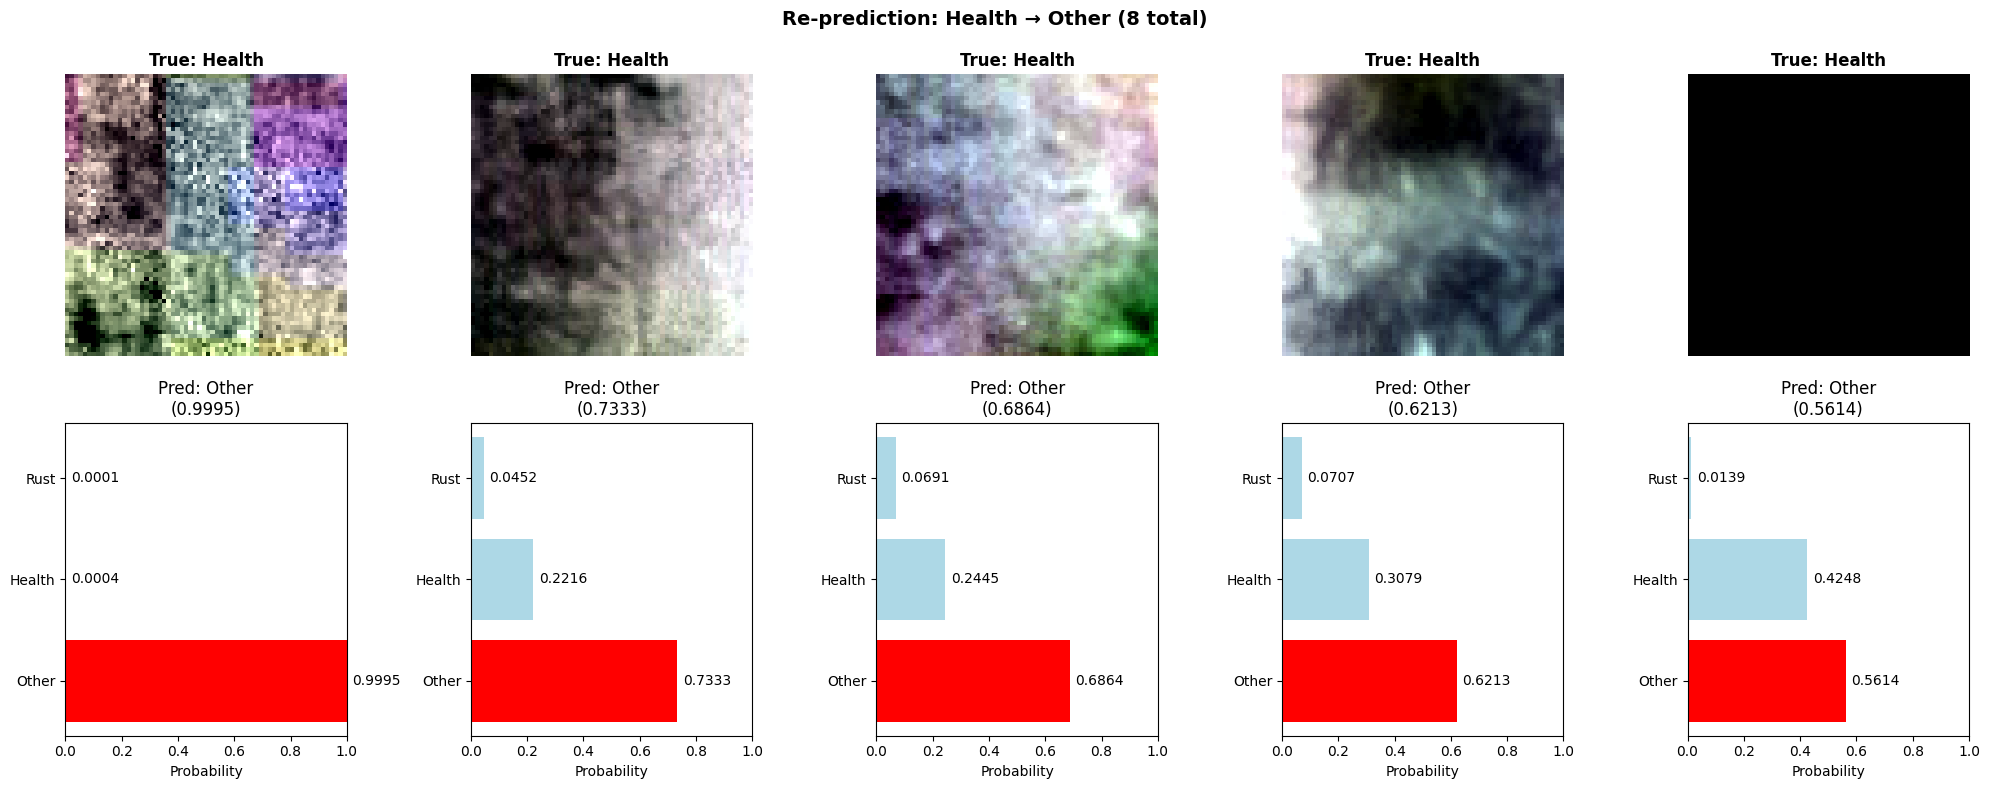

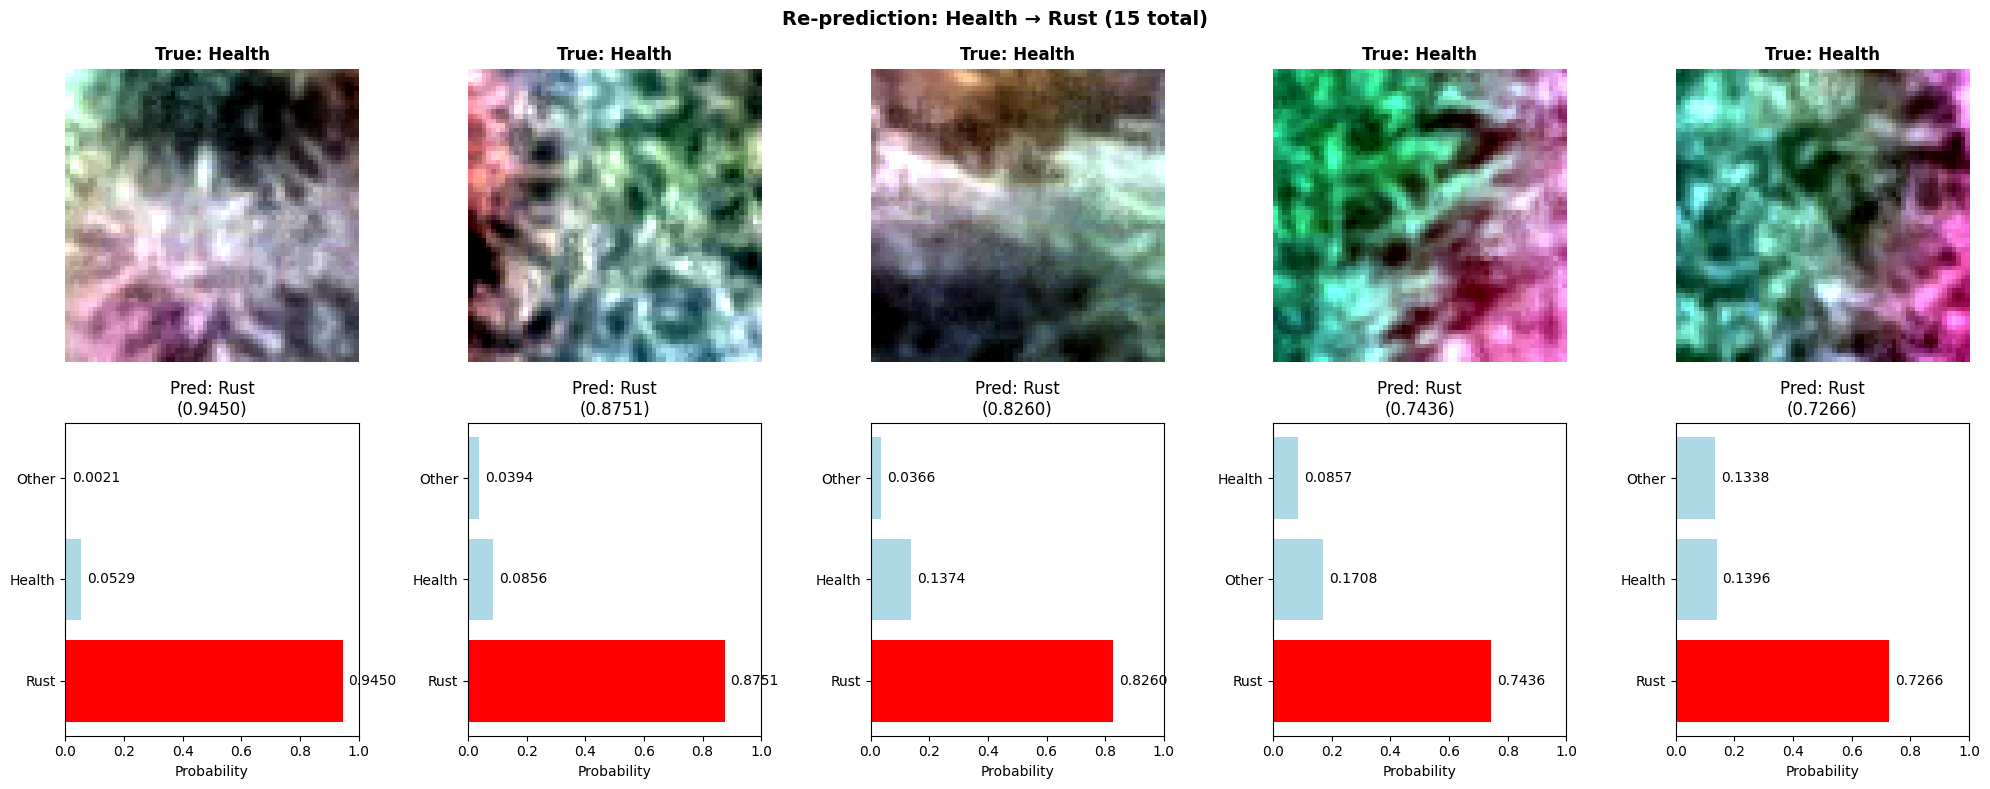

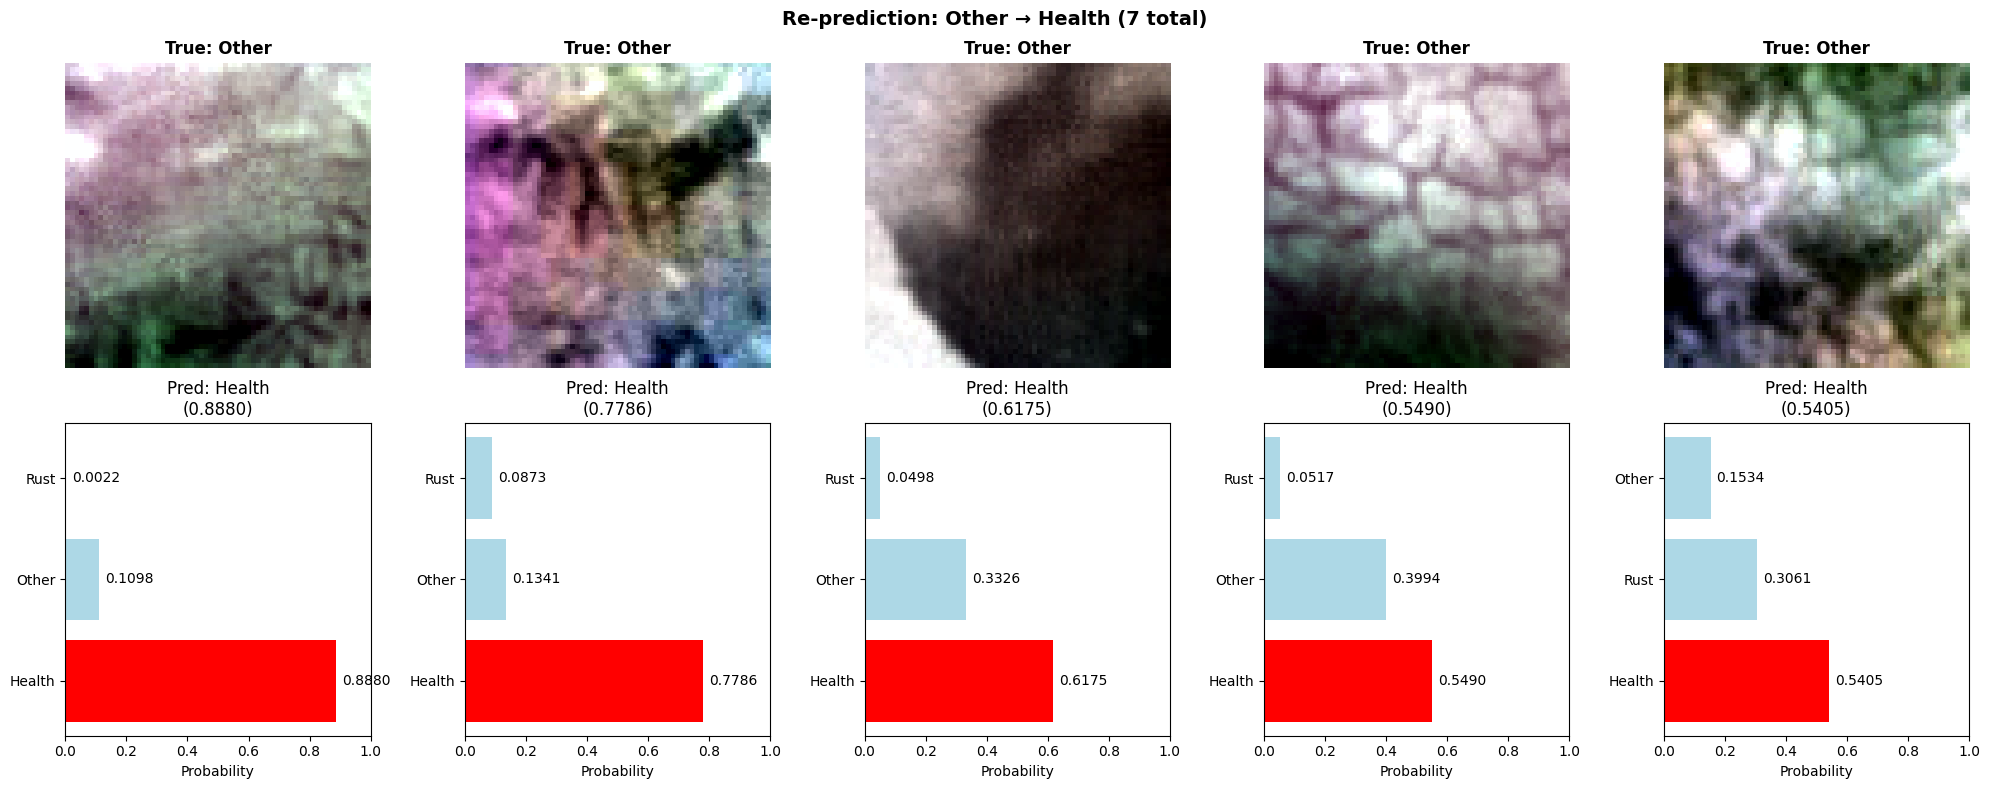

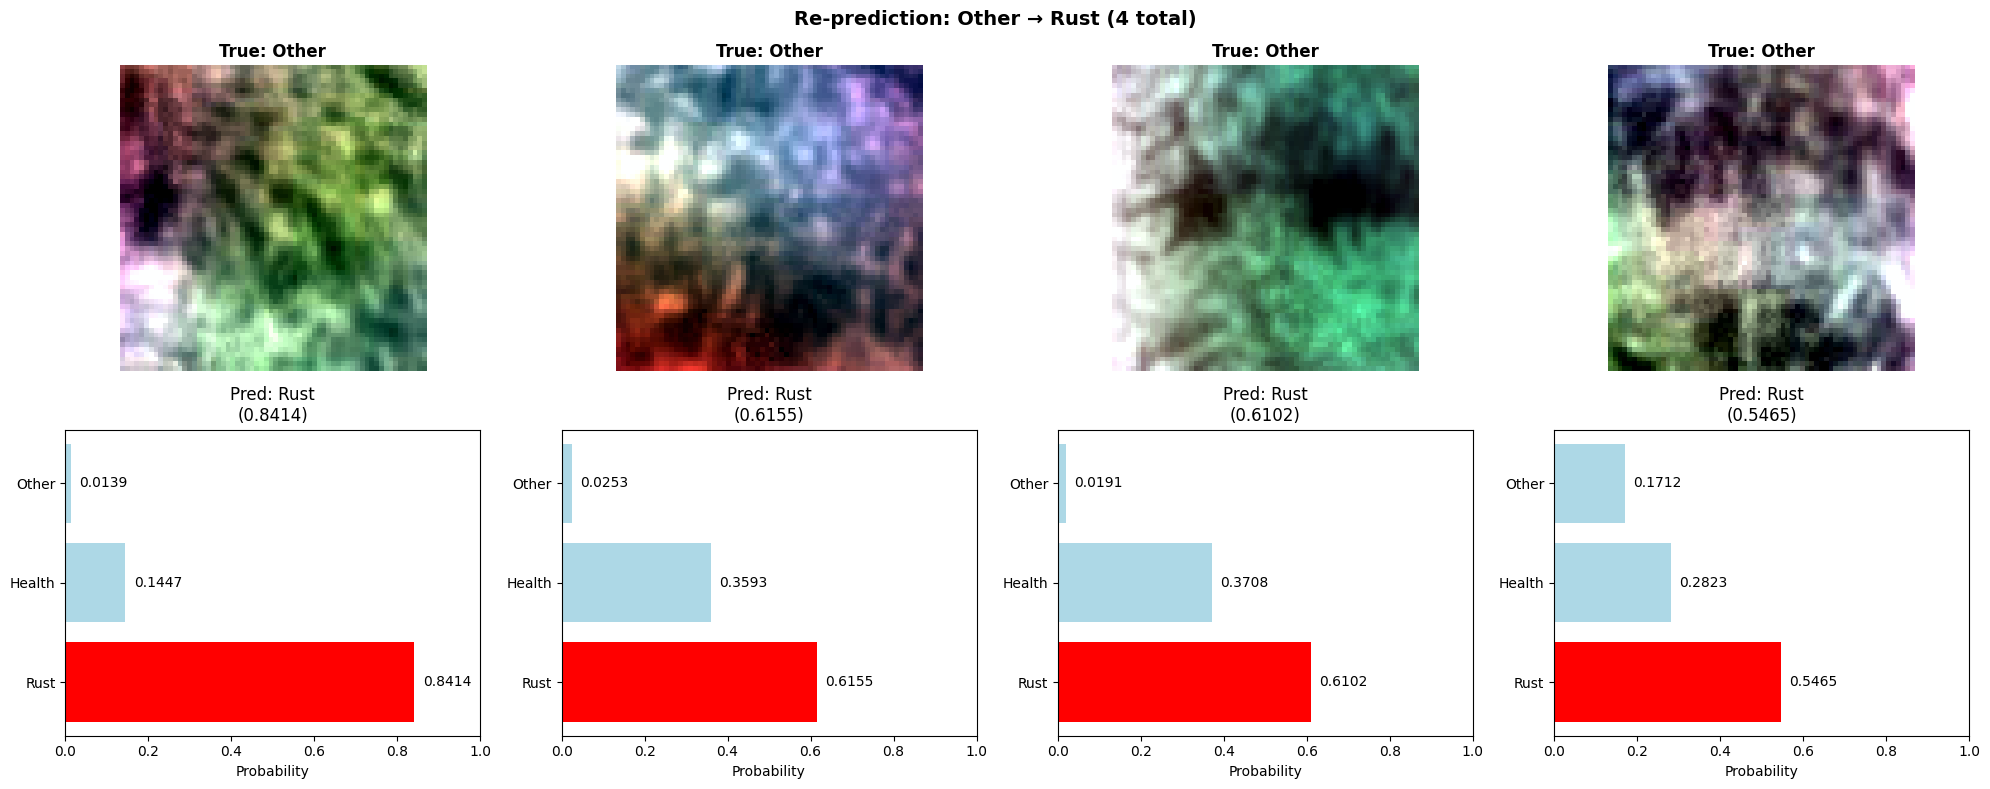

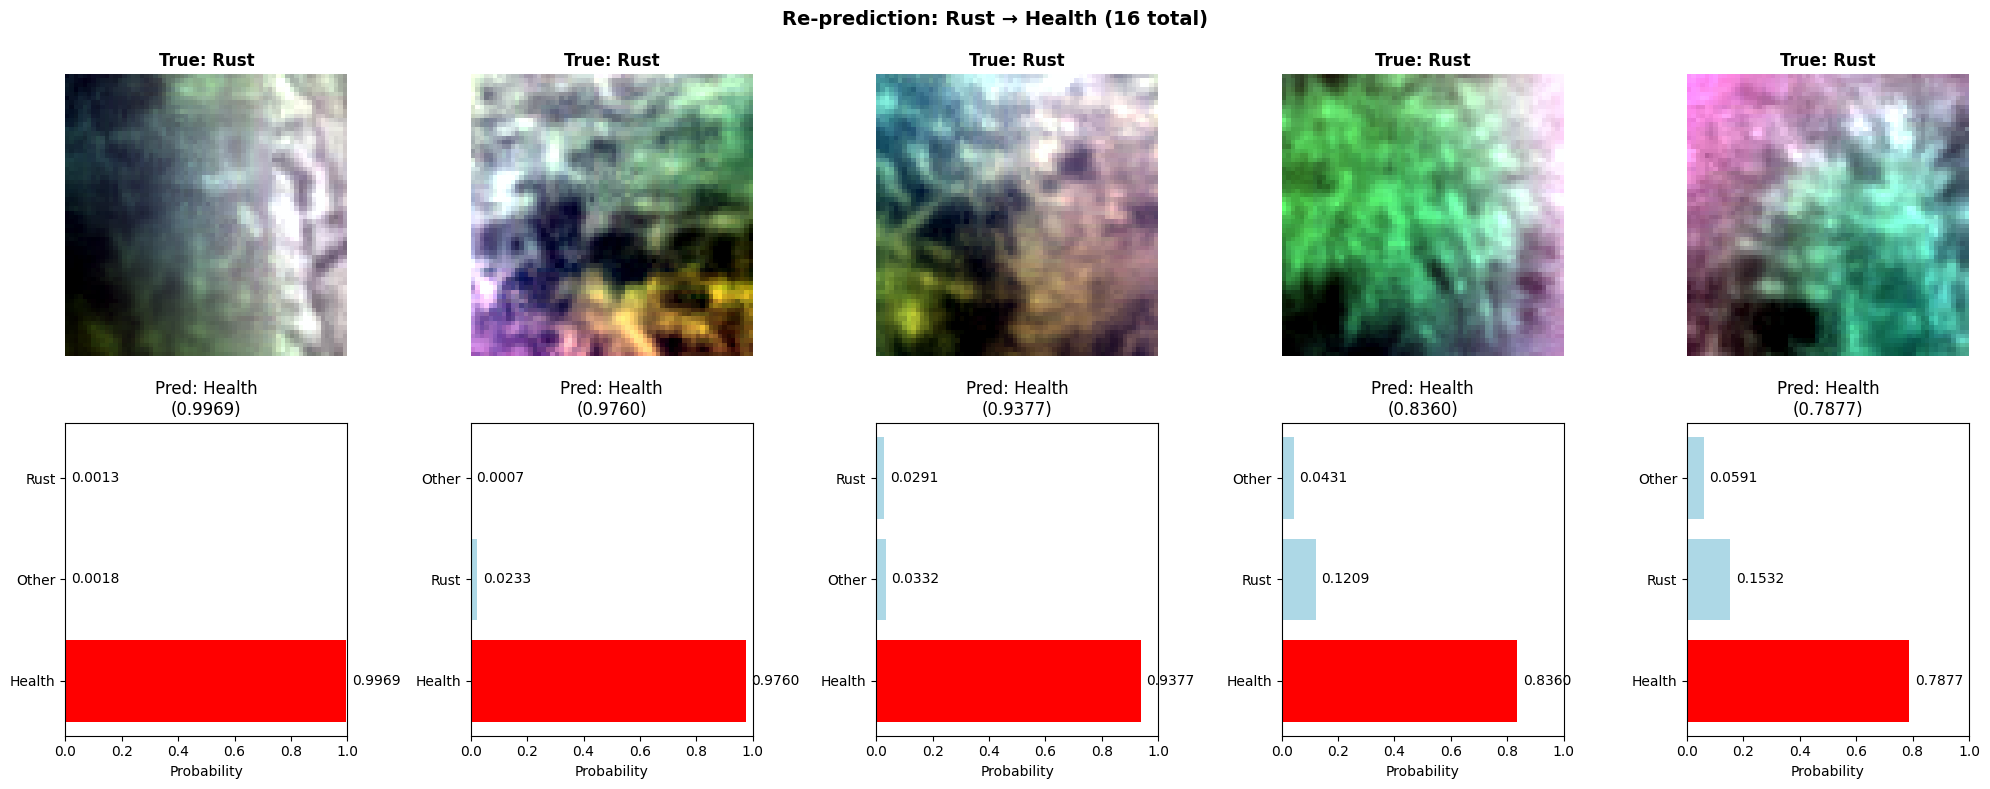

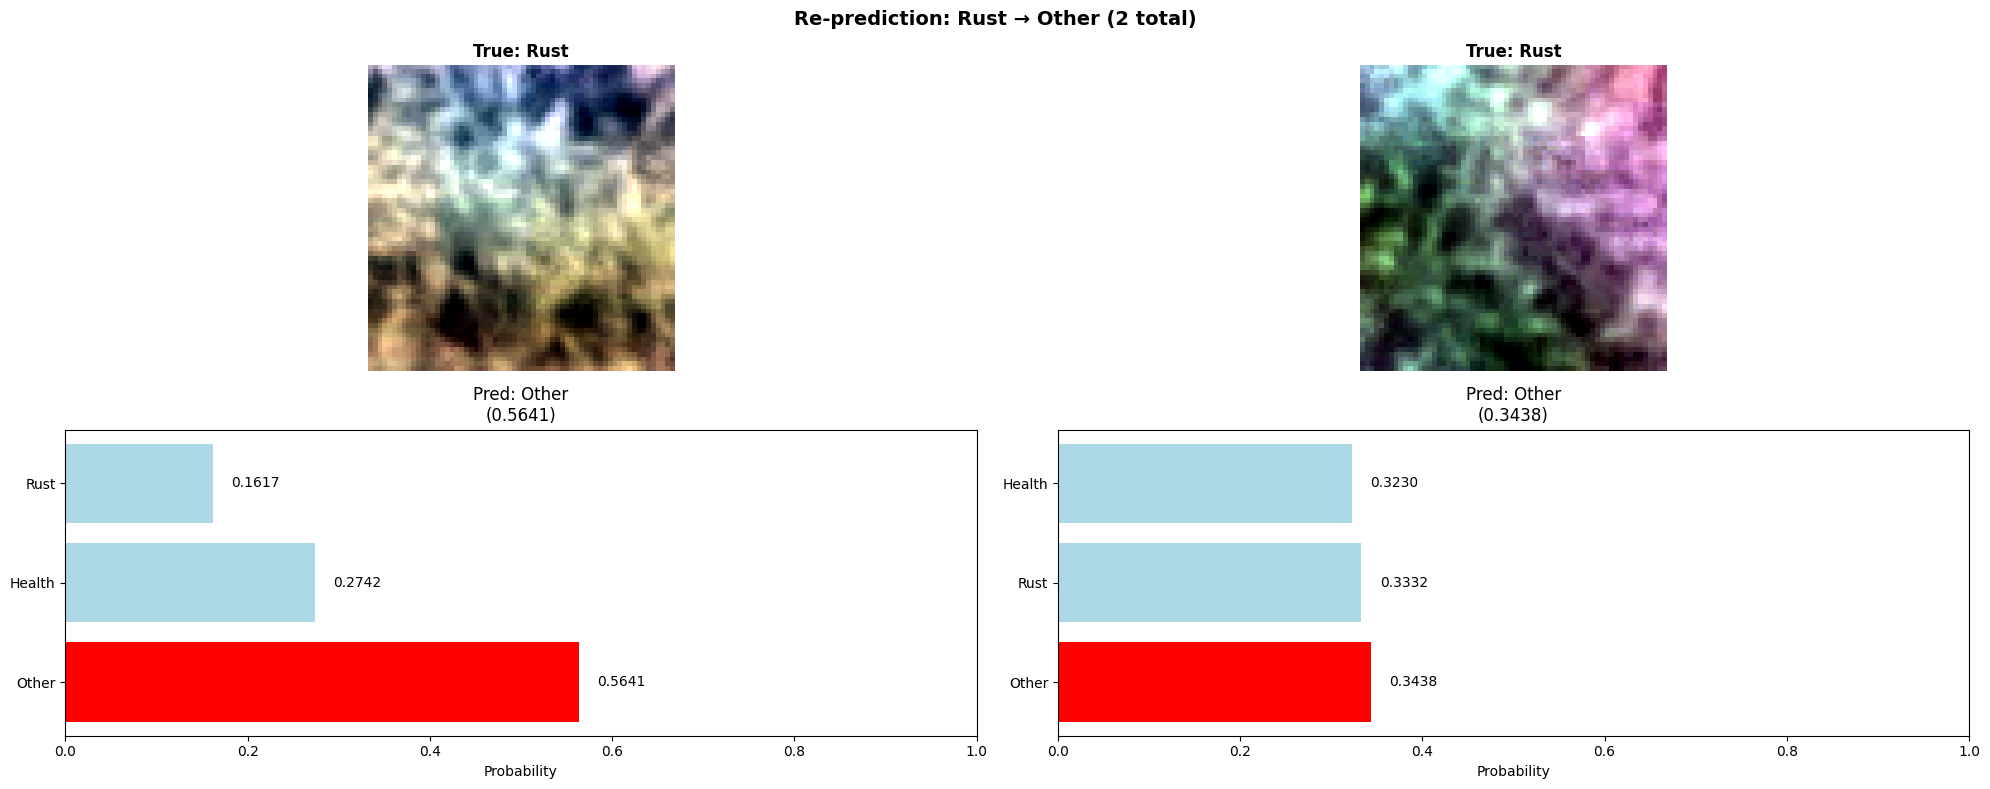

In [46]:
# Re-predict misclassified images
print("=== Re-predicting Misclassified Images ===\n")

# Collect all misclassified images with their predictions
misclassified_data = []

with torch.no_grad():
    val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
    
    for idx, (images, labels) in enumerate(val_dl):
        images = images.to(device)
        outputs = model(images)
        
        # Get top-k predictions
        probabilities = torch.softmax(outputs, dim=1)
        top_k_probs, top_k_indices = torch.topk(probabilities, 3, dim=1)
        
        pred = outputs.argmax(dim=1).cpu().numpy()[0]
        true = labels.numpy()[0]
        
        if pred != true:
            true_label = val_ds.idx_to_class[true]
            pred_label = val_ds.idx_to_class[pred]
            confidence = probabilities[0, pred].item()
            
            misclassified_data.append({
                'idx': idx,
                'true_label': true_label,
                'pred_label': pred_label,
                'confidence': confidence,
                'top3_labels': [val_ds.idx_to_class[i.item()] for i in top_k_indices[0]],
                'top3_probs': [p.item() for p in top_k_probs[0]],
                'filename': val_ds.files[idx]
            })

# Sort by confidence (most confident wrong predictions first)
misclassified_data.sort(key=lambda x: x['confidence'], reverse=True)

print(f"Total misclassified images: {len(misclassified_data)}\n")

# Display detailed predictions
print("Top 10 Most Confident Misclassified Predictions:")
print("-" * 100)
for i, item in enumerate(misclassified_data[:10]):
    print(f"{i+1}. Image: {item['filename']}")
    print(f"   True Label: {item['true_label']}")
    print(f"   Predicted: {item['pred_label']} (Confidence: {item['confidence']:.4f})")
    print(f"   Top-3 Predictions:")
    for j, (lbl, prob) in enumerate(zip(item['top3_labels'], item['top3_probs'])):
        print(f"      {j+1}. {lbl}: {prob:.4f}")
    print()

# Visualize re-predictions
print("\n=== Visualizing Re-Predictions ===\n")

for (true_lbl, pred_lbl), _ in sorted(misclassified.items()):
    items = [item for item in misclassified_data if item['true_label'] == true_lbl and item['pred_label'] == pred_lbl]
    
    if not items:
        continue
    
    num_show = min(5, len(items))
    fig, axes = plt.subplots(2, num_show, 
                             figsize=(20, 8),
                             squeeze=False)
    
    fig.suptitle(f"Re-prediction: {true_lbl} → {pred_lbl} ({len(items)} total)", 
                 fontsize=14, fontweight='bold')
    
    for i in range(num_show):
        item = items[i]
        idx = item['idx']
        img_tensor, _ = val_ds[idx]
        img_display = denormalize_image(img_tensor)
        
        # Image
        axes[0, i].imshow(img_display)
        axes[0, i].set_title(f"True: {item['true_label']}", fontweight='bold')
        axes[0, i].axis('off')
        
        # Predictions bar chart
        top3_labels = item['top3_labels']
        top3_probs = item['top3_probs']
        colors = ['red' if lbl == item['pred_label'] else 'lightblue' for lbl in top3_labels]
        
        axes[1, i].barh(top3_labels, top3_probs, color=colors)
        axes[1, i].set_xlim(0, 1)
        axes[1, i].set_title(f"Pred: {item['pred_label']}\n({item['confidence']:.4f})")
        axes[1, i].set_xlabel("Probability")
        
        for j, (lbl, prob) in enumerate(zip(top3_labels, top3_probs)):
            axes[1, i].text(prob + 0.02, j, f'{prob:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()

In [47]:
# List all misclassified images by category
print("=" * 80)
print("MISCLASSIFIED IMAGES - ORGANIZED BY TRUE LABEL → PREDICTED LABEL")
print("=" * 80)

# Dictionary to store misclassified images
misclassified_by_type = {}

with torch.no_grad():
    val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
    
    for idx, (images, labels) in enumerate(val_dl):
        images = images.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1).cpu().numpy()[0]
        true = labels.numpy()[0]
        
        # Only process misclassified
        if pred != true:
            true_label = val_ds.idx_to_class[true]
            pred_label = val_ds.idx_to_class[pred]
            filename = val_ds.files[idx]
            
            # Create key for this misclassification type
            key = f"{true_label} → {pred_label}"
            
            if key not in misclassified_by_type:
                misclassified_by_type[key] = []
            
            misclassified_by_type[key].append(filename)

# Sort and display
total_misclassified = sum(len(v) for v in misclassified_by_type.values())
print(f"\nTOTAL MISCLASSIFIED: {total_misclassified} images\n")

# Display organized by category
for key in sorted(misclassified_by_type.keys()):
    filenames = misclassified_by_type[key]
    print(f"\n{key} ({len(filenames)} images):")
    print("-" * 80)
    for filename in sorted(filenames):
        print(f"  • {filename}")

# Summary
print(f"\n\n{'=' * 80}")
print("SUMMARY")
print("=" * 80)
for key in sorted(misclassified_by_type.keys()):
    print(f"{key}: {len(misclassified_by_type[key])} images")

MISCLASSIFIED IMAGES - ORGANIZED BY TRUE LABEL → PREDICTED LABEL

TOTAL MISCLASSIFIED: 52 images


Health → Other (8 images):
--------------------------------------------------------------------------------
  • Health_hyper_106.png
  • Health_hyper_109.png
  • Health_hyper_145.png
  • Health_hyper_153.png
  • Health_hyper_36.png
  • Health_hyper_65.png
  • Health_hyper_66.png
  • Health_hyper_76.png

Health → Rust (15 images):
--------------------------------------------------------------------------------
  • Health_hyper_105.png
  • Health_hyper_133.png
  • Health_hyper_14.png
  • Health_hyper_151.png
  • Health_hyper_164.png
  • Health_hyper_175.png
  • Health_hyper_179.png
  • Health_hyper_199.png
  • Health_hyper_25.png
  • Health_hyper_6.png
  • Health_hyper_63.png
  • Health_hyper_70.png
  • Health_hyper_77.png
  • Health_hyper_80.png
  • Health_hyper_93.png

Other → Health (7 images):
--------------------------------------------------------------------------------
  • Other_hyp